# Santander Customer Satisfaction Prediction

- https://www.kaggle.com/competitions/santander-customer-satisfaction/overview
- Santander Customer Satisfaction Prediction : 분류 예측
- Note: The "TARGET" column is the variable to predict. It equals 1 for unsatisfied customers and 0 for satisfied customers.
- 사용할 분류 모델 : XGBoost, LightGBM
- 성능 평가 : 대부분 만족(0)이고 불만족(1)한 데이터는 일부일것이므로 정확도 수치보다 ROC-AUC 가 더 적합.

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./train_santander.csv")
print('dataset shape : ', cust_df.shape)
cust_df.head(3)

dataset shape :  (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [2]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [3]:
#이진분류의 경우, target 의 분포가 균일한지 확인할 필요가 있다. 대부분 만족이며, 4$의 고객만이 불만족.
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] ==1]['TARGET'].count()
total_cnt = cust_df['TARGET'].count()

print(f'unsatisfied 비율은 {unsatisfied_cnt/total_cnt:.2f}')

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [4]:
#각 피처의 값 분포 확인
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
#확인 결과,
#(1) var3 칼럼의 경우 min 이 -999999. 다른 값에 비해 너무 편차가 심하므로 가장 많은 2로 replace 하겠음.
#(2) ID 피처는 단순 식별자에 불과하므로 피처를 드롭하겠음.
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID', axis = 1, inplace = True)

## Seperate Train / Test data

In [7]:
#피처 세트와 레이블 세트 분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치하므로 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print(f'피처 데이터 shape:{X_features.shape}')

피처 데이터 shape:(76020, 369)


- 피처(Feature) : 데이터 세트의 일반 속성
- 레이블, 클래스, 타겟(값), 결정(값) : 데이터의 학습을 위해 주어지는 정답 데이터. 분류의 경우 레이블 또는 클래스로 지칭
- 즉, 분류라는 것은 다른 일반적인 속성(피처) 를 통해서 레이블을 예측하는 것.
- 따라서, 피처 세트와 레이블 세트를 분리하여 별도의 데이터 세트로 저장해야 함.

In [8]:
# 불균형한 데이터는 학습/테스트에 균일하게 들어가줘야한다.
# train_test_split의 stratify=y_labels 추가.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                   test_size = 0.2, random_state = 0, stratify = y_labels)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(f'학습 세트 Shape: { X_train.shape}, 테스트 세트 Shape:{X_test.shape}')

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960438
1    0.039562
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.960405
1    0.039595
Name: TARGET, dtype: float64


- x_train: 학습용 피처 세트
- x_test: 테스트용 피처 세트
- y_train: 학습용 레이블(타겟) 세트
- y_test: 테스트용 레이블(타겟) 세트

## XGBoost 모델 학습과 하이퍼파라미터 튜닝

In [10]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators = 500, random_state =156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100,
           eval_metric ="auc", eval_set = [(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print(f'ROC AUC : {xgb_roc_score}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.4 MB/s eta 0:00:00m eta 0:00:010:00:01


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82570	validation_1-auc:0.79283
[1]	validation_0-auc:0.84010	validation_1-auc:0.80737
[2]	validation_0-auc:0.84361	validation_1-auc:0.81021
[3]	validation_0-auc:0.84783	validation_1-auc:0.81287
[4]	validation_0-auc:0.85123	validation_1-auc:0.81469
[5]	validation_0-auc:0.85518	validation_1-auc:0.81860
[6]	validation_0-auc:0.85922	validation_1-auc:0.81977
[7]	validation_0-auc:0.86238	validation_1-auc:0.82034
[8]	validation_0-auc:0.86570	validation_1-auc:0.82147
[9]	validation_0-auc:0.86798	validation_1-auc:0.82301
[10]	validation_0-auc:0.87104	validation_1-auc:0.82379
[11]	validation_0-auc:0.87448	validation_1-auc:0.82456
[12]	validation_0-auc:0.87687	validation_1-auc:0.82401
[13]	validation_0-auc:0.87918	validation_1-auc:0.82467
[14]	validation_0-auc:0.88081	validation_1-auc:0.82508
[15]	validation_0-auc:0.88331	validation_1-auc:0.82379
[16]	validation_0-auc:0.88569	validation_1-auc:0.82457
[17]	validation_0-auc:0.88674	validation_1-auc:0.82453
[18]	validation_0-au

테스트 데이터 세트로 예측 시, ROC-AUC 는 0.82507이다. 하이퍼파라미터 튜닝을 해보자.

- 칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree 하이퍼파라미터만 일차 튜닝 대상으로 하겠음.
- 학습시간이 오래걸리는 ML 모델의 경우, 하이퍼파라미터 튜닝 시의 팁은 먼저 2~3개의 파라미터를 결합해 최적 파라미터를 찾아낸 후 이 최적 파라미터를 기반으로 다시 1~2개의 파라미터를 결합해 파라미터 튜닝을 수행하는 것.

In [11]:
#GridSearchCV 를 이용하여 하이퍼파라미터 튜닝 
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)
params = {
    'max_depth' : [5,7],
    'min_child_weight' :[1,3],
    'colsample_bytree' : [0.5, 0.75]
}

#하이퍼파라미터 테스트의 수행 속도를 향상 시키기 위해 cv를 시정하지 않음.
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train,y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC:{xgb_roc_score}')

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72299	validation_1-auc:0.69701
[1]	validation_0-auc:0.74228	validation_1-auc:0.71436
[2]	validation_0-auc:0.82250	validation_1-auc:0.79197
[3]	validation_0-auc:0.83339	validation_1-auc:0.80272
[4]	validation_0-auc:0.84302	validation_1-auc:0.80918
[5]	validation_0-auc:0.84560	validation_1-auc:0.81146
[6]	validation_0-auc:0.84528	validation_1-auc:0.81021
[7]	validation_0-auc:0.85103	validation_1-auc:0.81501
[8]	validation_0-auc:0.85062	validation_1-auc:0.81263
[9]	validation_0-auc:0.84826	validation_1-auc:0.80985
[10]	validation_0-auc:0.85449	validation_1-auc:0.81471
[11]	validation_0-auc:0.85779	validation_1-auc:0.81772
[12]	validation_0-auc:0.85933	validation_1-auc:0.81964
[13]	validation_0-auc:0.86000	validation_1-auc:0.81801
[14]	validation_0-auc:0.86157	validation_1-auc:0.81899
[15]	validation_0-auc:0.86474	validation_1-auc:0.82076
[16]	validation_0-auc:0.86511	validation_1-auc:0.82021
[17]	validation_0-auc:0.86685	validation_1-auc:0.82140
[18]	validation_0-au

[32]	validation_0-auc:0.88276	validation_1-auc:0.81842
[33]	validation_0-auc:0.88299	validation_1-auc:0.81833
[34]	validation_0-auc:0.88354	validation_1-auc:0.81715
[35]	validation_0-auc:0.88377	validation_1-auc:0.81701
[36]	validation_0-auc:0.88438	validation_1-auc:0.81580
[37]	validation_0-auc:0.88464	validation_1-auc:0.81619
[38]	validation_0-auc:0.88483	validation_1-auc:0.81604
[39]	validation_0-auc:0.88494	validation_1-auc:0.81593
[40]	validation_0-auc:0.88599	validation_1-auc:0.81604
[41]	validation_0-auc:0.88626	validation_1-auc:0.81591
[42]	validation_0-auc:0.88649	validation_1-auc:0.81602
[43]	validation_0-auc:0.88679	validation_1-auc:0.81595
[44]	validation_0-auc:0.88716	validation_1-auc:0.81566
[45]	validation_0-auc:0.88790	validation_1-auc:0.81508
[46]	validation_0-auc:0.88803	validation_1-auc:0.81500
[47]	validation_0-auc:0.88832	validation_1-auc:0.81504
[0]	validation_0-auc:0.72788	validation_1-auc:0.70243
[1]	validation_0-auc:0.75305	validation_1-auc:0.71989
[2]	validati

[34]	validation_0-auc:0.87658	validation_1-auc:0.82287
[35]	validation_0-auc:0.87691	validation_1-auc:0.82269
[36]	validation_0-auc:0.87712	validation_1-auc:0.82235
[37]	validation_0-auc:0.87795	validation_1-auc:0.82187
[38]	validation_0-auc:0.87804	validation_1-auc:0.82133
[39]	validation_0-auc:0.87889	validation_1-auc:0.82116
[40]	validation_0-auc:0.87907	validation_1-auc:0.82109
[41]	validation_0-auc:0.87936	validation_1-auc:0.82128
[42]	validation_0-auc:0.87956	validation_1-auc:0.82135
[43]	validation_0-auc:0.87997	validation_1-auc:0.82097
[44]	validation_0-auc:0.88099	validation_1-auc:0.82021
[45]	validation_0-auc:0.88121	validation_1-auc:0.82027
[46]	validation_0-auc:0.88161	validation_1-auc:0.81953
[47]	validation_0-auc:0.88241	validation_1-auc:0.81911
[48]	validation_0-auc:0.88250	validation_1-auc:0.81917
[49]	validation_0-auc:0.88315	validation_1-auc:0.81857
[50]	validation_0-auc:0.88398	validation_1-auc:0.81867
[51]	validation_0-auc:0.88466	validation_1-auc:0.81807
[52]	valid

[20]	validation_0-auc:0.86699	validation_1-auc:0.82369
[21]	validation_0-auc:0.86866	validation_1-auc:0.82453
[22]	validation_0-auc:0.86937	validation_1-auc:0.82493
[23]	validation_0-auc:0.86977	validation_1-auc:0.82481
[24]	validation_0-auc:0.87030	validation_1-auc:0.82468
[25]	validation_0-auc:0.87189	validation_1-auc:0.82405
[26]	validation_0-auc:0.87259	validation_1-auc:0.82439
[27]	validation_0-auc:0.87359	validation_1-auc:0.82374
[28]	validation_0-auc:0.87406	validation_1-auc:0.82344
[29]	validation_0-auc:0.87467	validation_1-auc:0.82253
[30]	validation_0-auc:0.87561	validation_1-auc:0.82244
[31]	validation_0-auc:0.87609	validation_1-auc:0.82252
[32]	validation_0-auc:0.87653	validation_1-auc:0.82226
[33]	validation_0-auc:0.87694	validation_1-auc:0.82249
[34]	validation_0-auc:0.87817	validation_1-auc:0.82230
[35]	validation_0-auc:0.87861	validation_1-auc:0.82249
[36]	validation_0-auc:0.87943	validation_1-auc:0.82150
[37]	validation_0-auc:0.87941	validation_1-auc:0.82159
[38]	valid

[15]	validation_0-auc:0.88526	validation_1-auc:0.81617
[16]	validation_0-auc:0.88750	validation_1-auc:0.81579
[17]	validation_0-auc:0.88951	validation_1-auc:0.81765
[18]	validation_0-auc:0.89242	validation_1-auc:0.81908
[19]	validation_0-auc:0.89333	validation_1-auc:0.81855
[20]	validation_0-auc:0.89437	validation_1-auc:0.81965
[21]	validation_0-auc:0.89631	validation_1-auc:0.82054
[22]	validation_0-auc:0.89711	validation_1-auc:0.82024
[23]	validation_0-auc:0.89758	validation_1-auc:0.81974
[24]	validation_0-auc:0.89843	validation_1-auc:0.81967
[25]	validation_0-auc:0.90016	validation_1-auc:0.81908
[26]	validation_0-auc:0.90123	validation_1-auc:0.81907
[27]	validation_0-auc:0.90373	validation_1-auc:0.81768
[28]	validation_0-auc:0.90421	validation_1-auc:0.81812
[29]	validation_0-auc:0.90533	validation_1-auc:0.81857
[30]	validation_0-auc:0.90560	validation_1-auc:0.81831
[31]	validation_0-auc:0.90585	validation_1-auc:0.81843
[32]	validation_0-auc:0.90630	validation_1-auc:0.81806
[33]	valid

[17]	validation_0-auc:0.89064	validation_1-auc:0.82105
[18]	validation_0-auc:0.89291	validation_1-auc:0.82119
[19]	validation_0-auc:0.89388	validation_1-auc:0.82078
[20]	validation_0-auc:0.89433	validation_1-auc:0.82075
[21]	validation_0-auc:0.89694	validation_1-auc:0.82096
[22]	validation_0-auc:0.89747	validation_1-auc:0.82073
[23]	validation_0-auc:0.89782	validation_1-auc:0.82040
[24]	validation_0-auc:0.89896	validation_1-auc:0.82018
[25]	validation_0-auc:0.90085	validation_1-auc:0.82023
[26]	validation_0-auc:0.90218	validation_1-auc:0.82007
[27]	validation_0-auc:0.90408	validation_1-auc:0.81877
[28]	validation_0-auc:0.90496	validation_1-auc:0.81986
[29]	validation_0-auc:0.90706	validation_1-auc:0.82020
[30]	validation_0-auc:0.90743	validation_1-auc:0.81952
[31]	validation_0-auc:0.90776	validation_1-auc:0.81868
[32]	validation_0-auc:0.90844	validation_1-auc:0.81867
[33]	validation_0-auc:0.90863	validation_1-auc:0.81872
[34]	validation_0-auc:0.90882	validation_1-auc:0.81845
[35]	valid

[14]	validation_0-auc:0.87712	validation_1-auc:0.81502
[15]	validation_0-auc:0.87943	validation_1-auc:0.81843
[16]	validation_0-auc:0.87974	validation_1-auc:0.81793
[17]	validation_0-auc:0.88135	validation_1-auc:0.82082
[18]	validation_0-auc:0.88468	validation_1-auc:0.82052
[19]	validation_0-auc:0.88600	validation_1-auc:0.82080
[20]	validation_0-auc:0.88666	validation_1-auc:0.82029
[21]	validation_0-auc:0.88809	validation_1-auc:0.82019
[22]	validation_0-auc:0.88899	validation_1-auc:0.81985
[23]	validation_0-auc:0.88964	validation_1-auc:0.82032
[24]	validation_0-auc:0.88995	validation_1-auc:0.82001
[25]	validation_0-auc:0.89086	validation_1-auc:0.82007
[26]	validation_0-auc:0.89208	validation_1-auc:0.82005
[27]	validation_0-auc:0.89362	validation_1-auc:0.81980
[28]	validation_0-auc:0.89391	validation_1-auc:0.81988
[29]	validation_0-auc:0.89544	validation_1-auc:0.82056
[30]	validation_0-auc:0.89580	validation_1-auc:0.82008
[31]	validation_0-auc:0.89607	validation_1-auc:0.82007
[32]	valid

[13]	validation_0-auc:0.86244	validation_1-auc:0.81912
[14]	validation_0-auc:0.86442	validation_1-auc:0.82158
[15]	validation_0-auc:0.86711	validation_1-auc:0.82304
[16]	validation_0-auc:0.86863	validation_1-auc:0.82370
[17]	validation_0-auc:0.86995	validation_1-auc:0.82400
[18]	validation_0-auc:0.87080	validation_1-auc:0.82444
[19]	validation_0-auc:0.87161	validation_1-auc:0.82501
[20]	validation_0-auc:0.87216	validation_1-auc:0.82524
[21]	validation_0-auc:0.87363	validation_1-auc:0.82527
[22]	validation_0-auc:0.87474	validation_1-auc:0.82471
[23]	validation_0-auc:0.87510	validation_1-auc:0.82486
[24]	validation_0-auc:0.87564	validation_1-auc:0.82469
[25]	validation_0-auc:0.87622	validation_1-auc:0.82401
[26]	validation_0-auc:0.87647	validation_1-auc:0.82389
[27]	validation_0-auc:0.87686	validation_1-auc:0.82422
[28]	validation_0-auc:0.87737	validation_1-auc:0.82414
[29]	validation_0-auc:0.87788	validation_1-auc:0.82384
[30]	validation_0-auc:0.87820	validation_1-auc:0.82350
[31]	valid

[7]	validation_0-auc:0.85124	validation_1-auc:0.81463
[8]	validation_0-auc:0.85149	validation_1-auc:0.81260
[9]	validation_0-auc:0.85097	validation_1-auc:0.80878
[10]	validation_0-auc:0.85665	validation_1-auc:0.81360
[11]	validation_0-auc:0.86001	validation_1-auc:0.81766
[12]	validation_0-auc:0.86256	validation_1-auc:0.82081
[13]	validation_0-auc:0.86340	validation_1-auc:0.81814
[14]	validation_0-auc:0.86549	validation_1-auc:0.82158
[15]	validation_0-auc:0.86733	validation_1-auc:0.82244
[16]	validation_0-auc:0.86894	validation_1-auc:0.82416
[17]	validation_0-auc:0.87049	validation_1-auc:0.82531
[18]	validation_0-auc:0.87148	validation_1-auc:0.82638
[19]	validation_0-auc:0.87243	validation_1-auc:0.82620
[20]	validation_0-auc:0.87370	validation_1-auc:0.82658
[21]	validation_0-auc:0.87423	validation_1-auc:0.82728
[22]	validation_0-auc:0.87519	validation_1-auc:0.82709
[23]	validation_0-auc:0.87615	validation_1-auc:0.82588
[24]	validation_0-auc:0.87689	validation_1-auc:0.82579
[25]	validati

[0]	validation_0-auc:0.74140	validation_1-auc:0.70819
[1]	validation_0-auc:0.76295	validation_1-auc:0.73065
[2]	validation_0-auc:0.82420	validation_1-auc:0.79009
[3]	validation_0-auc:0.83748	validation_1-auc:0.80315
[4]	validation_0-auc:0.84260	validation_1-auc:0.80806
[5]	validation_0-auc:0.84654	validation_1-auc:0.81051
[6]	validation_0-auc:0.84527	validation_1-auc:0.80709
[7]	validation_0-auc:0.85042	validation_1-auc:0.81289
[8]	validation_0-auc:0.84986	validation_1-auc:0.80852
[9]	validation_0-auc:0.84925	validation_1-auc:0.80589
[10]	validation_0-auc:0.85582	validation_1-auc:0.81342
[11]	validation_0-auc:0.85876	validation_1-auc:0.81732
[12]	validation_0-auc:0.86086	validation_1-auc:0.81972
[13]	validation_0-auc:0.86244	validation_1-auc:0.81932
[14]	validation_0-auc:0.86457	validation_1-auc:0.82080
[15]	validation_0-auc:0.86589	validation_1-auc:0.82215
[16]	validation_0-auc:0.86725	validation_1-auc:0.82283
[17]	validation_0-auc:0.86850	validation_1-auc:0.82310
[18]	validation_0-au

[50]	validation_0-auc:0.88653	validation_1-auc:0.82032
[0]	validation_0-auc:0.73792	validation_1-auc:0.69734
[1]	validation_0-auc:0.75867	validation_1-auc:0.72104
[2]	validation_0-auc:0.82613	validation_1-auc:0.79411
[3]	validation_0-auc:0.83573	validation_1-auc:0.80426
[4]	validation_0-auc:0.84231	validation_1-auc:0.81204
[5]	validation_0-auc:0.84610	validation_1-auc:0.81612
[6]	validation_0-auc:0.84362	validation_1-auc:0.81136
[7]	validation_0-auc:0.85009	validation_1-auc:0.81528
[8]	validation_0-auc:0.85065	validation_1-auc:0.81351
[9]	validation_0-auc:0.85032	validation_1-auc:0.80824
[10]	validation_0-auc:0.85679	validation_1-auc:0.81342
[11]	validation_0-auc:0.85970	validation_1-auc:0.81809
[12]	validation_0-auc:0.86183	validation_1-auc:0.81999
[13]	validation_0-auc:0.86304	validation_1-auc:0.81822
[14]	validation_0-auc:0.86526	validation_1-auc:0.82027
[15]	validation_0-auc:0.86617	validation_1-auc:0.82186
[16]	validation_0-auc:0.86748	validation_1-auc:0.82162
[17]	validation_0-au

[1]	validation_0-auc:0.77295	validation_1-auc:0.72719
[2]	validation_0-auc:0.83686	validation_1-auc:0.79305
[3]	validation_0-auc:0.84911	validation_1-auc:0.80565
[4]	validation_0-auc:0.85575	validation_1-auc:0.81053
[5]	validation_0-auc:0.85941	validation_1-auc:0.81331
[6]	validation_0-auc:0.86062	validation_1-auc:0.81131
[7]	validation_0-auc:0.86681	validation_1-auc:0.81611
[8]	validation_0-auc:0.86868	validation_1-auc:0.81027
[9]	validation_0-auc:0.86924	validation_1-auc:0.80673
[10]	validation_0-auc:0.87636	validation_1-auc:0.81285
[11]	validation_0-auc:0.88055	validation_1-auc:0.81745
[12]	validation_0-auc:0.88349	validation_1-auc:0.82158
[13]	validation_0-auc:0.88462	validation_1-auc:0.81945
[14]	validation_0-auc:0.88706	validation_1-auc:0.82238
[15]	validation_0-auc:0.89015	validation_1-auc:0.82282
[16]	validation_0-auc:0.89197	validation_1-auc:0.82416
[17]	validation_0-auc:0.89416	validation_1-auc:0.82333
[18]	validation_0-auc:0.89544	validation_1-auc:0.82235
[19]	validation_0-a

[10]	validation_0-auc:0.87161	validation_1-auc:0.81290
[11]	validation_0-auc:0.87488	validation_1-auc:0.81812
[12]	validation_0-auc:0.87736	validation_1-auc:0.82169
[13]	validation_0-auc:0.87793	validation_1-auc:0.81938
[14]	validation_0-auc:0.88077	validation_1-auc:0.82182
[15]	validation_0-auc:0.88311	validation_1-auc:0.82369
[16]	validation_0-auc:0.88379	validation_1-auc:0.82351
[17]	validation_0-auc:0.88498	validation_1-auc:0.82273
[18]	validation_0-auc:0.88704	validation_1-auc:0.82233
[19]	validation_0-auc:0.88742	validation_1-auc:0.82209
[20]	validation_0-auc:0.88838	validation_1-auc:0.82269
[21]	validation_0-auc:0.88993	validation_1-auc:0.82248
[22]	validation_0-auc:0.89037	validation_1-auc:0.82214
[23]	validation_0-auc:0.89055	validation_1-auc:0.82181
[24]	validation_0-auc:0.89144	validation_1-auc:0.82087
[25]	validation_0-auc:0.89176	validation_1-auc:0.82064
[26]	validation_0-auc:0.89320	validation_1-auc:0.81967
[27]	validation_0-auc:0.89433	validation_1-auc:0.81987
[28]	valid

[21]	validation_0-auc:0.89145	validation_1-auc:0.81844
[22]	validation_0-auc:0.89191	validation_1-auc:0.81862
[23]	validation_0-auc:0.89241	validation_1-auc:0.81834
[24]	validation_0-auc:0.89269	validation_1-auc:0.81816
[25]	validation_0-auc:0.89329	validation_1-auc:0.81848
[26]	validation_0-auc:0.89357	validation_1-auc:0.81792
[27]	validation_0-auc:0.89509	validation_1-auc:0.81781
[28]	validation_0-auc:0.89657	validation_1-auc:0.81760
[29]	validation_0-auc:0.89676	validation_1-auc:0.81769
[30]	validation_0-auc:0.89689	validation_1-auc:0.81719
[31]	validation_0-auc:0.89714	validation_1-auc:0.81692
[32]	validation_0-auc:0.89747	validation_1-auc:0.81682
[33]	validation_0-auc:0.89758	validation_1-auc:0.81680
[34]	validation_0-auc:0.89797	validation_1-auc:0.81657
[35]	validation_0-auc:0.89828	validation_1-auc:0.81578
[36]	validation_0-auc:0.89880	validation_1-auc:0.81615
[37]	validation_0-auc:0.89911	validation_1-auc:0.81604
[38]	validation_0-auc:0.89949	validation_1-auc:0.81643
[39]	valid

In [12]:
#위에서 GridSearchCV 로 구한 최적 하이퍼파라미터를 XGBoost 에 적용하고 다시 학습해 ROC-AUC 측정

# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소
# 최적의 하이퍼파라미터 추가함. (max_depth=5, min_child_weight=3, colsample_bytree=0.75)
#reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5,\
                        min_child_weight=3, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.74824	validation_1-auc:0.71476
[1]	validation_0-auc:0.80819	validation_1-auc:0.77923
[2]	validation_0-auc:0.82731	validation_1-auc:0.79748
[3]	validation_0-auc:0.83103	validation_1-auc:0.80132
[4]	validation_0-auc:0.83281	validation_1-auc:0.80353
[5]	validation_0-auc:0.83532	validation_1-auc:0.80551
[6]	validation_0-auc:0.83779	validation_1-auc:0.80852
[7]	validation_0-auc:0.83722	validation_1-auc:0.80540
[8]	validation_0-auc:0.83881	validation_1-auc:0.80783
[9]	validation_0-auc:0.84022	validation_1-auc:0.80905
[10]	validation_0-auc:0.84158	validation_1-auc:0.80962
[11]	validation_0-auc:0.84217	validation_1-auc:0.81016
[12]	validation_0-auc:0.84198	validation_1-auc:0.80949
[13]	validation_0-auc:0.84218	validation_1-auc:0.80985
[14]	validation_0-auc:0.84302	validation_1-auc:0.81128
[15]	validation_0-auc:0.84157	validation_1-auc:0.80923
[16]	validation_0-auc:0.84238	validation_1-auc:0.80990
[17]	validation_0-auc:0.84239	validation_1-auc:0.80950
[18]	validation_0-au

[149]	validation_0-auc:0.85975	validation_1-auc:0.82149
[150]	validation_0-auc:0.85982	validation_1-auc:0.82136
[151]	validation_0-auc:0.85992	validation_1-auc:0.82108
[152]	validation_0-auc:0.86025	validation_1-auc:0.82152
[153]	validation_0-auc:0.86042	validation_1-auc:0.82183
[154]	validation_0-auc:0.86062	validation_1-auc:0.82196
[155]	validation_0-auc:0.86088	validation_1-auc:0.82221
[156]	validation_0-auc:0.86112	validation_1-auc:0.82231
[157]	validation_0-auc:0.86124	validation_1-auc:0.82217
[158]	validation_0-auc:0.86147	validation_1-auc:0.82231
[159]	validation_0-auc:0.86162	validation_1-auc:0.82244
[160]	validation_0-auc:0.86172	validation_1-auc:0.82221
[161]	validation_0-auc:0.86183	validation_1-auc:0.82237
[162]	validation_0-auc:0.86196	validation_1-auc:0.82240
[163]	validation_0-auc:0.86207	validation_1-auc:0.82221
[164]	validation_0-auc:0.86227	validation_1-auc:0.82238
[165]	validation_0-auc:0.86245	validation_1-auc:0.82219
[166]	validation_0-auc:0.86255	validation_1-auc:

[296]	validation_0-auc:0.87489	validation_1-auc:0.82680
[297]	validation_0-auc:0.87494	validation_1-auc:0.82686
[298]	validation_0-auc:0.87502	validation_1-auc:0.82681
[299]	validation_0-auc:0.87510	validation_1-auc:0.82678
[300]	validation_0-auc:0.87516	validation_1-auc:0.82672
[301]	validation_0-auc:0.87522	validation_1-auc:0.82670
[302]	validation_0-auc:0.87527	validation_1-auc:0.82672
[303]	validation_0-auc:0.87533	validation_1-auc:0.82666
[304]	validation_0-auc:0.87536	validation_1-auc:0.82668
[305]	validation_0-auc:0.87542	validation_1-auc:0.82673
[306]	validation_0-auc:0.87548	validation_1-auc:0.82672
[307]	validation_0-auc:0.87558	validation_1-auc:0.82674
[308]	validation_0-auc:0.87566	validation_1-auc:0.82676
[309]	validation_0-auc:0.87573	validation_1-auc:0.82676
[310]	validation_0-auc:0.87579	validation_1-auc:0.82676
[311]	validation_0-auc:0.87585	validation_1-auc:0.82679
[312]	validation_0-auc:0.87596	validation_1-auc:0.82678
[313]	validation_0-auc:0.87604	validation_1-auc:

[443]	validation_0-auc:0.88120	validation_1-auc:0.82622
[444]	validation_0-auc:0.88131	validation_1-auc:0.82620
[445]	validation_0-auc:0.88133	validation_1-auc:0.82619
[446]	validation_0-auc:0.88141	validation_1-auc:0.82622
[447]	validation_0-auc:0.88145	validation_1-auc:0.82624
[448]	validation_0-auc:0.88146	validation_1-auc:0.82624
[449]	validation_0-auc:0.88151	validation_1-auc:0.82624
[450]	validation_0-auc:0.88155	validation_1-auc:0.82623
[451]	validation_0-auc:0.88157	validation_1-auc:0.82623
[452]	validation_0-auc:0.88163	validation_1-auc:0.82625
[453]	validation_0-auc:0.88166	validation_1-auc:0.82623
[454]	validation_0-auc:0.88168	validation_1-auc:0.82621
[455]	validation_0-auc:0.88170	validation_1-auc:0.82622
[456]	validation_0-auc:0.88173	validation_1-auc:0.82622
[457]	validation_0-auc:0.88175	validation_1-auc:0.82622
[458]	validation_0-auc:0.88178	validation_1-auc:0.82621
[459]	validation_0-auc:0.88189	validation_1-auc:0.82621
[460]	validation_0-auc:0.88192	validation_1-auc:

- 하이퍼파라미터 수정 이후 이전 ROC AUC 보다 다소 향상된 것을 확인.
- 그러나, 앙상블 계열 알고리즘에서 하이퍼파라미터의 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 그리 많지 않음.앙상블 알고리즘이 과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기 때문.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

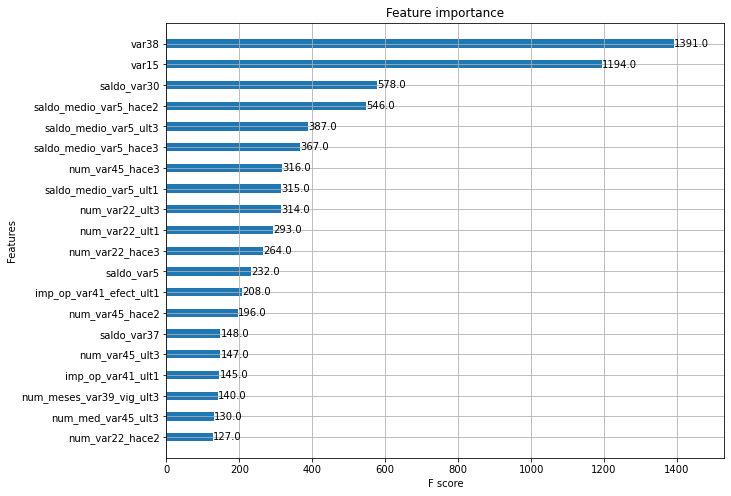

In [13]:
#튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내보자. (xgboost 의 plot_importance() 이용)
#XGBoost 의 예측 성능을 좌우하는 중요한 피처를 순서대로 볼 수 있음. 

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

## LightGBM 모델 학습과 하이퍼파라미터 튜닝

In [21]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators = 500)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric = 'auc', eval_set = evals, verbose =True)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print(f'ROC AUC: {lgbm_roc_score:.4f}')

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.795963	valid_0's binary_logloss: 0.159288
[2]	valid_0's auc: 0.801789	valid_0's binary_logloss: 0.155038
[3]	valid_0's auc: 0.803367	valid_0's binary_logloss: 0.15185
[4]	valid_0's auc: 0.805168	valid_0's binary_logloss: 0.14961
[5]	valid_0's auc: 0.809401	valid_0's binary_logloss: 0.147695
[6]	valid_0's auc: 0.810671	valid_0's binary_logloss: 0.146234
[7]	valid_0's auc: 0.815356	valid_0's binary_logloss: 0.144877
[8]	valid_0's auc: 0.816777	valid_0's binary_logloss: 0.143783
[9]	valid_0's auc: 0.817821	valid_0's binary_logloss: 0.143084
[10]	valid_0's auc: 0.818637	valid_0's binary_logloss: 0.142272
[11]	valid_0's auc: 0.81939	valid_0's binary_logloss: 0.141623
[12]	valid_0's auc: 0.821106	valid_0's binary_logloss: 0.141043
[13]	valid_0's auc: 0.822008	valid_0's binary_logloss: 0.140628
[14]	valid_0's auc: 0.822584	valid_0's binary_logloss: 0.140198
[15]	valid_0's auc: 0.822291	valid_0's binary_logloss: 0.139909
[16]	valid_0's auc: 0.821862	valid_0's binary_loglos

[143]	valid_0's auc: 0.811453	valid_0's binary_logloss: 0.142082
ROC AUC: 0.8239


- 확실히 XGBoost 보다 LightGBM 이 훨씬 더 빠르다.

In [22]:
#GridSearchCV 를 이용하여 하이퍼파라미터 튜닝 
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
LGBM_clf = LGBMClassifier(n_estimators=100)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv 를 지정하지 않습니다. 
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.824588	valid_0's binary_logloss: 0.157382	valid_1's auc: 0.795136	valid_1's binary_logloss: 0.159389
[2]	valid_0's auc: 0.832653	valid_0's binary_logloss: 0.151792	valid_1's auc: 0.801554	valid_1's binary_logloss: 0.154959
[3]	valid_0's auc: 0.838487	valid_0's binary_logloss: 0.147752	valid_1's auc: 0.804632	valid_1's binary_logloss: 0.151808
[4]	valid_0's auc: 0.84201	valid_0's binary_logloss: 0.144662	valid_1's auc: 0.807473	valid_1's binary_logloss: 0.149313
[5]	valid_0's auc: 0.847672	valid_0's binary_logloss: 0.142057	valid_1's auc: 0.814421	valid_1's binary_logloss: 0.147394
[6]	valid_0's auc: 0.849939	valid_0's binary_logloss: 0.140012	valid_1's auc: 0.816098	valid_1's binary_logloss: 0.145946
[7]	valid_0's auc: 0.851296	valid_0's binary_logloss: 0.138265	valid_1's auc: 0.817273	valid_1's binary_logloss: 0.144617
[8]	valid_0's auc: 0.852879	valid_0's binary_logloss: 0.136726	valid_1's auc: 0.817978	valid_1's binary_logloss: 0.143581
[9]	valid_0's auc: 0.8534

[11]	valid_0's auc: 0.859035	valid_0's binary_logloss: 0.133356	valid_1's auc: 0.818897	valid_1's binary_logloss: 0.141423
[12]	valid_0's auc: 0.861152	valid_0's binary_logloss: 0.132392	valid_1's auc: 0.818888	valid_1's binary_logloss: 0.140925
[13]	valid_0's auc: 0.862968	valid_0's binary_logloss: 0.131546	valid_1's auc: 0.818838	valid_1's binary_logloss: 0.140472
[14]	valid_0's auc: 0.864544	valid_0's binary_logloss: 0.130816	valid_1's auc: 0.818888	valid_1's binary_logloss: 0.140154
[15]	valid_0's auc: 0.865564	valid_0's binary_logloss: 0.130146	valid_1's auc: 0.818489	valid_1's binary_logloss: 0.139929
[16]	valid_0's auc: 0.866503	valid_0's binary_logloss: 0.12954	valid_1's auc: 0.8188	valid_1's binary_logloss: 0.139689
[17]	valid_0's auc: 0.867528	valid_0's binary_logloss: 0.128943	valid_1's auc: 0.819096	valid_1's binary_logloss: 0.1395
[18]	valid_0's auc: 0.868418	valid_0's binary_logloss: 0.128434	valid_1's auc: 0.819567	valid_1's binary_logloss: 0.139225
[19]	valid_0's auc: 0

[29]	valid_0's auc: 0.878599	valid_0's binary_logloss: 0.124086	valid_1's auc: 0.825682	valid_1's binary_logloss: 0.137456
[30]	valid_0's auc: 0.879331	valid_0's binary_logloss: 0.123772	valid_1's auc: 0.825747	valid_1's binary_logloss: 0.137458
[31]	valid_0's auc: 0.880213	valid_0's binary_logloss: 0.123503	valid_1's auc: 0.826127	valid_1's binary_logloss: 0.137382
[32]	valid_0's auc: 0.880836	valid_0's binary_logloss: 0.123243	valid_1's auc: 0.825755	valid_1's binary_logloss: 0.137402
[33]	valid_0's auc: 0.881453	valid_0's binary_logloss: 0.122975	valid_1's auc: 0.825597	valid_1's binary_logloss: 0.137411
[34]	valid_0's auc: 0.882559	valid_0's binary_logloss: 0.122715	valid_1's auc: 0.826384	valid_1's binary_logloss: 0.13731
[35]	valid_0's auc: 0.883437	valid_0's binary_logloss: 0.122445	valid_1's auc: 0.826447	valid_1's binary_logloss: 0.137286
[36]	valid_0's auc: 0.884191	valid_0's binary_logloss: 0.12216	valid_1's auc: 0.826179	valid_1's binary_logloss: 0.1373
[37]	valid_0's auc: 

[32]	valid_0's auc: 0.881251	valid_0's binary_logloss: 0.123235	valid_1's auc: 0.823749	valid_1's binary_logloss: 0.137994
[33]	valid_0's auc: 0.881917	valid_0's binary_logloss: 0.122975	valid_1's auc: 0.823695	valid_1's binary_logloss: 0.138002
[34]	valid_0's auc: 0.882751	valid_0's binary_logloss: 0.122651	valid_1's auc: 0.823256	valid_1's binary_logloss: 0.13811
[35]	valid_0's auc: 0.883135	valid_0's binary_logloss: 0.122457	valid_1's auc: 0.823342	valid_1's binary_logloss: 0.138124
[36]	valid_0's auc: 0.883794	valid_0's binary_logloss: 0.122194	valid_1's auc: 0.823095	valid_1's binary_logloss: 0.138138
[37]	valid_0's auc: 0.884987	valid_0's binary_logloss: 0.121891	valid_1's auc: 0.823242	valid_1's binary_logloss: 0.138109
[38]	valid_0's auc: 0.885575	valid_0's binary_logloss: 0.121649	valid_1's auc: 0.823154	valid_1's binary_logloss: 0.13813
[39]	valid_0's auc: 0.886317	valid_0's binary_logloss: 0.121382	valid_1's auc: 0.82276	valid_1's binary_logloss: 0.138211
[40]	valid_0's auc:

[45]	valid_0's auc: 0.89112	valid_0's binary_logloss: 0.119631	valid_1's auc: 0.817684	valid_1's binary_logloss: 0.139375
[46]	valid_0's auc: 0.891632	valid_0's binary_logloss: 0.119408	valid_1's auc: 0.817115	valid_1's binary_logloss: 0.13949
[47]	valid_0's auc: 0.892105	valid_0's binary_logloss: 0.119187	valid_1's auc: 0.816869	valid_1's binary_logloss: 0.139599
[48]	valid_0's auc: 0.892693	valid_0's binary_logloss: 0.118978	valid_1's auc: 0.81641	valid_1's binary_logloss: 0.139694
[49]	valid_0's auc: 0.893265	valid_0's binary_logloss: 0.118769	valid_1's auc: 0.816202	valid_1's binary_logloss: 0.139717
[1]	valid_0's auc: 0.824588	valid_0's binary_logloss: 0.157382	valid_1's auc: 0.795136	valid_1's binary_logloss: 0.159389
[2]	valid_0's auc: 0.832653	valid_0's binary_logloss: 0.151792	valid_1's auc: 0.801554	valid_1's binary_logloss: 0.154959
[3]	valid_0's auc: 0.838487	valid_0's binary_logloss: 0.147752	valid_1's auc: 0.804632	valid_1's binary_logloss: 0.151808
[4]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.826765	valid_0's binary_logloss: 0.157422	valid_1's auc: 0.794017	valid_1's binary_logloss: 0.159161
[2]	valid_0's auc: 0.833077	valid_0's binary_logloss: 0.151923	valid_1's auc: 0.798918	valid_1's binary_logloss: 0.154784
[3]	valid_0's auc: 0.835999	valid_0's binary_logloss: 0.147996	valid_1's auc: 0.800992	valid_1's binary_logloss: 0.151783
[4]	valid_0's auc: 0.843213	valid_0's binary_logloss: 0.14485	valid_1's auc: 0.807306	valid_1's binary_logloss: 0.149385
[5]	valid_0's auc: 0.845503	valid_0's binary_logloss: 0.142368	valid_1's auc: 0.809445	valid_1's binary_logloss: 0.147536
[6]	valid_0's auc: 0.851777	valid_0's binary_logloss: 0.140187	valid_1's auc: 0.815523	valid_1's binary_logloss: 0.146081
[7]	valid_0's auc: 0.853084	valid_0's binary_logloss: 0.138412	valid_1's auc: 0.815703	valid_1's binary_logloss: 0.144756
[8]	valid_0's auc: 0.85451	valid_0's binary_logloss: 0.136843	valid_1's auc: 0.818057	valid_1's binary_logloss: 0.14363
[9]	valid_0's auc: 0.855518

[14]	valid_0's auc: 0.864043	valid_0's binary_logloss: 0.130881	valid_1's auc: 0.824334	valid_1's binary_logloss: 0.139256
[15]	valid_0's auc: 0.864811	valid_0's binary_logloss: 0.130236	valid_1's auc: 0.824071	valid_1's binary_logloss: 0.138951
[16]	valid_0's auc: 0.866259	valid_0's binary_logloss: 0.129598	valid_1's auc: 0.824956	valid_1's binary_logloss: 0.13867
[17]	valid_0's auc: 0.867117	valid_0's binary_logloss: 0.12904	valid_1's auc: 0.825202	valid_1's binary_logloss: 0.138462
[18]	valid_0's auc: 0.86795	valid_0's binary_logloss: 0.128496	valid_1's auc: 0.825426	valid_1's binary_logloss: 0.138226
[19]	valid_0's auc: 0.869086	valid_0's binary_logloss: 0.128014	valid_1's auc: 0.825529	valid_1's binary_logloss: 0.138104
[20]	valid_0's auc: 0.870198	valid_0's binary_logloss: 0.127553	valid_1's auc: 0.825205	valid_1's binary_logloss: 0.137996
[21]	valid_0's auc: 0.871229	valid_0's binary_logloss: 0.127092	valid_1's auc: 0.825025	valid_1's binary_logloss: 0.137931
[22]	valid_0's auc:

[18]	valid_0's auc: 0.867292	valid_0's binary_logloss: 0.128514	valid_1's auc: 0.821589	valid_1's binary_logloss: 0.139203
[19]	valid_0's auc: 0.868303	valid_0's binary_logloss: 0.128034	valid_1's auc: 0.821025	valid_1's binary_logloss: 0.139083
[20]	valid_0's auc: 0.86993	valid_0's binary_logloss: 0.127542	valid_1's auc: 0.821332	valid_1's binary_logloss: 0.138929
[21]	valid_0's auc: 0.871171	valid_0's binary_logloss: 0.127108	valid_1's auc: 0.821831	valid_1's binary_logloss: 0.138778
[22]	valid_0's auc: 0.871873	valid_0's binary_logloss: 0.126683	valid_1's auc: 0.822165	valid_1's binary_logloss: 0.138655
[23]	valid_0's auc: 0.872697	valid_0's binary_logloss: 0.126291	valid_1's auc: 0.822065	valid_1's binary_logloss: 0.138571
[24]	valid_0's auc: 0.873381	valid_0's binary_logloss: 0.125907	valid_1's auc: 0.822183	valid_1's binary_logloss: 0.138496
[25]	valid_0's auc: 0.874186	valid_0's binary_logloss: 0.125566	valid_1's auc: 0.822889	valid_1's binary_logloss: 0.138319
[26]	valid_0's au

[26]	valid_0's auc: 0.878008	valid_0's binary_logloss: 0.124845	valid_1's auc: 0.819078	valid_1's binary_logloss: 0.139112
[27]	valid_0's auc: 0.878617	valid_0's binary_logloss: 0.124519	valid_1's auc: 0.818903	valid_1's binary_logloss: 0.139064
[28]	valid_0's auc: 0.879661	valid_0's binary_logloss: 0.12414	valid_1's auc: 0.819125	valid_1's binary_logloss: 0.139028
[29]	valid_0's auc: 0.880282	valid_0's binary_logloss: 0.123842	valid_1's auc: 0.818867	valid_1's binary_logloss: 0.139063
[30]	valid_0's auc: 0.880943	valid_0's binary_logloss: 0.123521	valid_1's auc: 0.819127	valid_1's binary_logloss: 0.138998
[31]	valid_0's auc: 0.881863	valid_0's binary_logloss: 0.123185	valid_1's auc: 0.819271	valid_1's binary_logloss: 0.138938
[32]	valid_0's auc: 0.883363	valid_0's binary_logloss: 0.122853	valid_1's auc: 0.819428	valid_1's binary_logloss: 0.13895
[33]	valid_0's auc: 0.884117	valid_0's binary_logloss: 0.122525	valid_1's auc: 0.819285	valid_1's binary_logloss: 0.139001
[34]	valid_0's auc

[47]	valid_0's auc: 0.912384	valid_0's binary_logloss: 0.110805	valid_1's auc: 0.822403	valid_1's binary_logloss: 0.138922
[48]	valid_0's auc: 0.912771	valid_0's binary_logloss: 0.110542	valid_1's auc: 0.822276	valid_1's binary_logloss: 0.138971
[49]	valid_0's auc: 0.913482	valid_0's binary_logloss: 0.110221	valid_1's auc: 0.822476	valid_1's binary_logloss: 0.13898
[50]	valid_0's auc: 0.913778	valid_0's binary_logloss: 0.109982	valid_1's auc: 0.82219	valid_1's binary_logloss: 0.139054
[51]	valid_0's auc: 0.914059	valid_0's binary_logloss: 0.109741	valid_1's auc: 0.822132	valid_1's binary_logloss: 0.139131
[52]	valid_0's auc: 0.91455	valid_0's binary_logloss: 0.109487	valid_1's auc: 0.822402	valid_1's binary_logloss: 0.139142
[53]	valid_0's auc: 0.915027	valid_0's binary_logloss: 0.10926	valid_1's auc: 0.821675	valid_1's binary_logloss: 0.139334
[1]	valid_0's auc: 0.832117	valid_0's binary_logloss: 0.156596	valid_1's auc: 0.790539	valid_1's binary_logloss: 0.15907
[2]	valid_0's auc: 0.8

[11]	valid_0's auc: 0.875239	valid_0's binary_logloss: 0.129814	valid_1's auc: 0.823339	valid_1's binary_logloss: 0.140201
[12]	valid_0's auc: 0.876463	valid_0's binary_logloss: 0.128722	valid_1's auc: 0.823184	valid_1's binary_logloss: 0.139752
[13]	valid_0's auc: 0.877928	valid_0's binary_logloss: 0.127634	valid_1's auc: 0.824011	valid_1's binary_logloss: 0.139405
[14]	valid_0's auc: 0.880015	valid_0's binary_logloss: 0.126626	valid_1's auc: 0.824273	valid_1's binary_logloss: 0.138994
[15]	valid_0's auc: 0.881375	valid_0's binary_logloss: 0.125749	valid_1's auc: 0.824583	valid_1's binary_logloss: 0.138664
[16]	valid_0's auc: 0.882908	valid_0's binary_logloss: 0.124993	valid_1's auc: 0.824347	valid_1's binary_logloss: 0.138415
[17]	valid_0's auc: 0.884588	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.824761	valid_1's binary_logloss: 0.138149
[18]	valid_0's auc: 0.886143	valid_0's binary_logloss: 0.12347	valid_1's auc: 0.825596	valid_1's binary_logloss: 0.137891
[19]	valid_0's au

[22]	valid_0's auc: 0.889085	valid_0's binary_logloss: 0.121371	valid_1's auc: 0.818982	valid_1's binary_logloss: 0.139061
[23]	valid_0's auc: 0.890679	valid_0's binary_logloss: 0.120824	valid_1's auc: 0.819192	valid_1's binary_logloss: 0.138983
[24]	valid_0's auc: 0.891749	valid_0's binary_logloss: 0.120271	valid_1's auc: 0.819752	valid_1's binary_logloss: 0.13885
[25]	valid_0's auc: 0.892721	valid_0's binary_logloss: 0.119797	valid_1's auc: 0.819652	valid_1's binary_logloss: 0.138853
[26]	valid_0's auc: 0.893869	valid_0's binary_logloss: 0.119334	valid_1's auc: 0.819766	valid_1's binary_logloss: 0.138786
[27]	valid_0's auc: 0.894998	valid_0's binary_logloss: 0.118864	valid_1's auc: 0.819227	valid_1's binary_logloss: 0.138861
[28]	valid_0's auc: 0.896117	valid_0's binary_logloss: 0.118341	valid_1's auc: 0.81867	valid_1's binary_logloss: 0.138938
[29]	valid_0's auc: 0.89756	valid_0's binary_logloss: 0.117873	valid_1's auc: 0.818812	valid_1's binary_logloss: 0.138904
[30]	valid_0's auc:

[35]	valid_0's auc: 0.904486	valid_0's binary_logloss: 0.114714	valid_1's auc: 0.819301	valid_1's binary_logloss: 0.139175
[36]	valid_0's auc: 0.905183	valid_0's binary_logloss: 0.114359	valid_1's auc: 0.819248	valid_1's binary_logloss: 0.13921
[37]	valid_0's auc: 0.906401	valid_0's binary_logloss: 0.113978	valid_1's auc: 0.819197	valid_1's binary_logloss: 0.139248
[38]	valid_0's auc: 0.906901	valid_0's binary_logloss: 0.113697	valid_1's auc: 0.819114	valid_1's binary_logloss: 0.139286
[39]	valid_0's auc: 0.907747	valid_0's binary_logloss: 0.113335	valid_1's auc: 0.819399	valid_1's binary_logloss: 0.139288
[40]	valid_0's auc: 0.908577	valid_0's binary_logloss: 0.112922	valid_1's auc: 0.81883	valid_1's binary_logloss: 0.139385
[41]	valid_0's auc: 0.909319	valid_0's binary_logloss: 0.112567	valid_1's auc: 0.818729	valid_1's binary_logloss: 0.139468
[42]	valid_0's auc: 0.909945	valid_0's binary_logloss: 0.112226	valid_1's auc: 0.818529	valid_1's binary_logloss: 0.139535
[1]	valid_0's auc:

[11]	valid_0's auc: 0.873617	valid_0's binary_logloss: 0.129711	valid_1's auc: 0.82141	valid_1's binary_logloss: 0.14078
[12]	valid_0's auc: 0.875124	valid_0's binary_logloss: 0.128578	valid_1's auc: 0.820791	valid_1's binary_logloss: 0.140416
[13]	valid_0's auc: 0.877551	valid_0's binary_logloss: 0.12751	valid_1's auc: 0.819914	valid_1's binary_logloss: 0.140224
[14]	valid_0's auc: 0.879142	valid_0's binary_logloss: 0.126506	valid_1's auc: 0.821193	valid_1's binary_logloss: 0.139809
[15]	valid_0's auc: 0.880493	valid_0's binary_logloss: 0.125652	valid_1's auc: 0.82125	valid_1's binary_logloss: 0.139512
[16]	valid_0's auc: 0.882248	valid_0's binary_logloss: 0.124799	valid_1's auc: 0.821894	valid_1's binary_logloss: 0.139191
[17]	valid_0's auc: 0.883851	valid_0's binary_logloss: 0.124007	valid_1's auc: 0.822123	valid_1's binary_logloss: 0.139005
[18]	valid_0's auc: 0.885527	valid_0's binary_logloss: 0.123257	valid_1's auc: 0.821622	valid_1's binary_logloss: 0.138925
[19]	valid_0's auc: 

[29]	valid_0's auc: 0.898433	valid_0's binary_logloss: 0.117319	valid_1's auc: 0.825608	valid_1's binary_logloss: 0.137337
[30]	valid_0's auc: 0.899317	valid_0's binary_logloss: 0.116883	valid_1's auc: 0.826208	valid_1's binary_logloss: 0.137215
[31]	valid_0's auc: 0.900275	valid_0's binary_logloss: 0.116419	valid_1's auc: 0.825773	valid_1's binary_logloss: 0.137275
[32]	valid_0's auc: 0.901066	valid_0's binary_logloss: 0.116012	valid_1's auc: 0.826168	valid_1's binary_logloss: 0.137249
[33]	valid_0's auc: 0.902364	valid_0's binary_logloss: 0.115567	valid_1's auc: 0.825814	valid_1's binary_logloss: 0.137305
[34]	valid_0's auc: 0.903307	valid_0's binary_logloss: 0.11515	valid_1's auc: 0.825482	valid_1's binary_logloss: 0.137408
[35]	valid_0's auc: 0.904467	valid_0's binary_logloss: 0.114744	valid_1's auc: 0.826222	valid_1's binary_logloss: 0.137322
[36]	valid_0's auc: 0.905455	valid_0's binary_logloss: 0.114346	valid_1's auc: 0.826161	valid_1's binary_logloss: 0.137355
[37]	valid_0's au

[37]	valid_0's auc: 0.905495	valid_0's binary_logloss: 0.114493	valid_1's auc: 0.817997	valid_1's binary_logloss: 0.13922
[38]	valid_0's auc: 0.906141	valid_0's binary_logloss: 0.114158	valid_1's auc: 0.817511	valid_1's binary_logloss: 0.139313
[39]	valid_0's auc: 0.907169	valid_0's binary_logloss: 0.113748	valid_1's auc: 0.818063	valid_1's binary_logloss: 0.139256
[40]	valid_0's auc: 0.907733	valid_0's binary_logloss: 0.113391	valid_1's auc: 0.818016	valid_1's binary_logloss: 0.139254
[41]	valid_0's auc: 0.908456	valid_0's binary_logloss: 0.113042	valid_1's auc: 0.818343	valid_1's binary_logloss: 0.139249
[42]	valid_0's auc: 0.909039	valid_0's binary_logloss: 0.112695	valid_1's auc: 0.817956	valid_1's binary_logloss: 0.139387
[43]	valid_0's auc: 0.90958	valid_0's binary_logloss: 0.112393	valid_1's auc: 0.817638	valid_1's binary_logloss: 0.139448
[44]	valid_0's auc: 0.910571	valid_0's binary_logloss: 0.111937	valid_1's auc: 0.817502	valid_1's binary_logloss: 0.139548
[45]	valid_0's auc

[12]	valid_0's auc: 0.857368	valid_0's binary_logloss: 0.132996	valid_1's auc: 0.820631	valid_1's binary_logloss: 0.140863
[13]	valid_0's auc: 0.858537	valid_0's binary_logloss: 0.132153	valid_1's auc: 0.822949	valid_1's binary_logloss: 0.140263
[14]	valid_0's auc: 0.860207	valid_0's binary_logloss: 0.131404	valid_1's auc: 0.822546	valid_1's binary_logloss: 0.139923
[15]	valid_0's auc: 0.86121	valid_0's binary_logloss: 0.130776	valid_1's auc: 0.823477	valid_1's binary_logloss: 0.139559
[16]	valid_0's auc: 0.862197	valid_0's binary_logloss: 0.130196	valid_1's auc: 0.823149	valid_1's binary_logloss: 0.139349
[17]	valid_0's auc: 0.863309	valid_0's binary_logloss: 0.12966	valid_1's auc: 0.822963	valid_1's binary_logloss: 0.139121
[18]	valid_0's auc: 0.864655	valid_0's binary_logloss: 0.129144	valid_1's auc: 0.823318	valid_1's binary_logloss: 0.138897
[19]	valid_0's auc: 0.86614	valid_0's binary_logloss: 0.128641	valid_1's auc: 0.823371	valid_1's binary_logloss: 0.138726
[20]	valid_0's auc:

[39]	valid_0's auc: 0.883882	valid_0's binary_logloss: 0.122355	valid_1's auc: 0.823442	valid_1's binary_logloss: 0.137755
[40]	valid_0's auc: 0.884602	valid_0's binary_logloss: 0.122096	valid_1's auc: 0.823469	valid_1's binary_logloss: 0.137754
[41]	valid_0's auc: 0.885395	valid_0's binary_logloss: 0.121828	valid_1's auc: 0.823245	valid_1's binary_logloss: 0.137806
[42]	valid_0's auc: 0.886018	valid_0's binary_logloss: 0.121602	valid_1's auc: 0.823178	valid_1's binary_logloss: 0.13784
[43]	valid_0's auc: 0.886513	valid_0's binary_logloss: 0.121401	valid_1's auc: 0.823122	valid_1's binary_logloss: 0.13788
[44]	valid_0's auc: 0.886995	valid_0's binary_logloss: 0.121179	valid_1's auc: 0.823087	valid_1's binary_logloss: 0.137944
[45]	valid_0's auc: 0.887618	valid_0's binary_logloss: 0.120957	valid_1's auc: 0.822682	valid_1's binary_logloss: 0.138038
[46]	valid_0's auc: 0.8882	valid_0's binary_logloss: 0.120789	valid_1's auc: 0.823017	valid_1's binary_logloss: 0.138022
[47]	valid_0's auc: 

[47]	valid_0's auc: 0.889012	valid_0's binary_logloss: 0.120249	valid_1's auc: 0.824552	valid_1's binary_logloss: 0.138047
[48]	valid_0's auc: 0.889474	valid_0's binary_logloss: 0.120029	valid_1's auc: 0.824433	valid_1's binary_logloss: 0.138069
[49]	valid_0's auc: 0.889779	valid_0's binary_logloss: 0.119838	valid_1's auc: 0.82416	valid_1's binary_logloss: 0.138163
[50]	valid_0's auc: 0.890327	valid_0's binary_logloss: 0.119591	valid_1's auc: 0.824505	valid_1's binary_logloss: 0.138098
[51]	valid_0's auc: 0.890795	valid_0's binary_logloss: 0.119368	valid_1's auc: 0.824512	valid_1's binary_logloss: 0.138111
[52]	valid_0's auc: 0.891388	valid_0's binary_logloss: 0.119176	valid_1's auc: 0.824311	valid_1's binary_logloss: 0.138143
[53]	valid_0's auc: 0.891996	valid_0's binary_logloss: 0.118981	valid_1's auc: 0.824379	valid_1's binary_logloss: 0.138165
[54]	valid_0's auc: 0.892421	valid_0's binary_logloss: 0.118821	valid_1's auc: 0.82424	valid_1's binary_logloss: 0.138209
[55]	valid_0's auc

[50]	valid_0's auc: 0.890001	valid_0's binary_logloss: 0.120009	valid_1's auc: 0.821552	valid_1's binary_logloss: 0.138229
[51]	valid_0's auc: 0.890456	valid_0's binary_logloss: 0.119819	valid_1's auc: 0.821316	valid_1's binary_logloss: 0.138297
[52]	valid_0's auc: 0.890936	valid_0's binary_logloss: 0.119603	valid_1's auc: 0.820865	valid_1's binary_logloss: 0.138401
[53]	valid_0's auc: 0.89143	valid_0's binary_logloss: 0.119413	valid_1's auc: 0.82073	valid_1's binary_logloss: 0.138447
[54]	valid_0's auc: 0.891796	valid_0's binary_logloss: 0.11923	valid_1's auc: 0.82066	valid_1's binary_logloss: 0.138496
[55]	valid_0's auc: 0.892398	valid_0's binary_logloss: 0.119013	valid_1's auc: 0.820498	valid_1's binary_logloss: 0.138536
[56]	valid_0's auc: 0.892959	valid_0's binary_logloss: 0.118856	valid_1's auc: 0.8202	valid_1's binary_logloss: 0.138595
[57]	valid_0's auc: 0.893447	valid_0's binary_logloss: 0.118676	valid_1's auc: 0.820342	valid_1's binary_logloss: 0.138579
[58]	valid_0's auc: 0.

[12]	valid_0's auc: 0.857368	valid_0's binary_logloss: 0.132996	valid_1's auc: 0.820631	valid_1's binary_logloss: 0.140863
[13]	valid_0's auc: 0.858537	valid_0's binary_logloss: 0.132153	valid_1's auc: 0.822949	valid_1's binary_logloss: 0.140263
[14]	valid_0's auc: 0.860207	valid_0's binary_logloss: 0.131404	valid_1's auc: 0.822546	valid_1's binary_logloss: 0.139923
[15]	valid_0's auc: 0.86121	valid_0's binary_logloss: 0.130776	valid_1's auc: 0.823477	valid_1's binary_logloss: 0.139559
[16]	valid_0's auc: 0.862197	valid_0's binary_logloss: 0.130196	valid_1's auc: 0.823149	valid_1's binary_logloss: 0.139349
[17]	valid_0's auc: 0.863309	valid_0's binary_logloss: 0.12966	valid_1's auc: 0.822963	valid_1's binary_logloss: 0.139121
[18]	valid_0's auc: 0.864655	valid_0's binary_logloss: 0.129144	valid_1's auc: 0.823318	valid_1's binary_logloss: 0.138897
[19]	valid_0's auc: 0.86614	valid_0's binary_logloss: 0.128641	valid_1's auc: 0.823371	valid_1's binary_logloss: 0.138726
[20]	valid_0's auc:

[30]	valid_0's auc: 0.877343	valid_0's binary_logloss: 0.124593	valid_1's auc: 0.823337	valid_1's binary_logloss: 0.137851
[31]	valid_0's auc: 0.87822	valid_0's binary_logloss: 0.124344	valid_1's auc: 0.823737	valid_1's binary_logloss: 0.137796
[32]	valid_0's auc: 0.879346	valid_0's binary_logloss: 0.124082	valid_1's auc: 0.823421	valid_1's binary_logloss: 0.137812
[33]	valid_0's auc: 0.879904	valid_0's binary_logloss: 0.123818	valid_1's auc: 0.823221	valid_1's binary_logloss: 0.137811
[34]	valid_0's auc: 0.880592	valid_0's binary_logloss: 0.123567	valid_1's auc: 0.823488	valid_1's binary_logloss: 0.137772
[35]	valid_0's auc: 0.881157	valid_0's binary_logloss: 0.123306	valid_1's auc: 0.823566	valid_1's binary_logloss: 0.137762
[36]	valid_0's auc: 0.881951	valid_0's binary_logloss: 0.123059	valid_1's auc: 0.823213	valid_1's binary_logloss: 0.137818
[37]	valid_0's auc: 0.882769	valid_0's binary_logloss: 0.122783	valid_1's auc: 0.823583	valid_1's binary_logloss: 0.137731
[38]	valid_0's au

[37]	valid_0's auc: 0.883049	valid_0's binary_logloss: 0.122562	valid_1's auc: 0.824879	valid_1's binary_logloss: 0.137813
[38]	valid_0's auc: 0.883652	valid_0's binary_logloss: 0.12233	valid_1's auc: 0.825274	valid_1's binary_logloss: 0.137757
[39]	valid_0's auc: 0.884324	valid_0's binary_logloss: 0.122087	valid_1's auc: 0.825121	valid_1's binary_logloss: 0.137809
[40]	valid_0's auc: 0.884936	valid_0's binary_logloss: 0.121823	valid_1's auc: 0.824854	valid_1's binary_logloss: 0.137848
[41]	valid_0's auc: 0.885559	valid_0's binary_logloss: 0.12159	valid_1's auc: 0.824841	valid_1's binary_logloss: 0.137888
[42]	valid_0's auc: 0.886222	valid_0's binary_logloss: 0.121351	valid_1's auc: 0.82474	valid_1's binary_logloss: 0.137928
[43]	valid_0's auc: 0.886965	valid_0's binary_logloss: 0.121143	valid_1's auc: 0.824915	valid_1's binary_logloss: 0.137888
[44]	valid_0's auc: 0.887583	valid_0's binary_logloss: 0.120896	valid_1's auc: 0.824805	valid_1's binary_logloss: 0.137917
[45]	valid_0's auc:

[47]	valid_0's auc: 0.88781	valid_0's binary_logloss: 0.120725	valid_1's auc: 0.8228	valid_1's binary_logloss: 0.137971
[48]	valid_0's auc: 0.888561	valid_0's binary_logloss: 0.120468	valid_1's auc: 0.82236	valid_1's binary_logloss: 0.138086
[49]	valid_0's auc: 0.8893	valid_0's binary_logloss: 0.120222	valid_1's auc: 0.821827	valid_1's binary_logloss: 0.13818
[50]	valid_0's auc: 0.890001	valid_0's binary_logloss: 0.120009	valid_1's auc: 0.821552	valid_1's binary_logloss: 0.138229
[51]	valid_0's auc: 0.890456	valid_0's binary_logloss: 0.119819	valid_1's auc: 0.821316	valid_1's binary_logloss: 0.138297
[52]	valid_0's auc: 0.890936	valid_0's binary_logloss: 0.119603	valid_1's auc: 0.820865	valid_1's binary_logloss: 0.138401
[53]	valid_0's auc: 0.89143	valid_0's binary_logloss: 0.119413	valid_1's auc: 0.82073	valid_1's binary_logloss: 0.138447
[54]	valid_0's auc: 0.891796	valid_0's binary_logloss: 0.11923	valid_1's auc: 0.82066	valid_1's binary_logloss: 0.138496
[55]	valid_0's auc: 0.89239

[11]	valid_0's auc: 0.870177	valid_0's binary_logloss: 0.130858	valid_1's auc: 0.821289	valid_1's binary_logloss: 0.14101
[12]	valid_0's auc: 0.87143	valid_0's binary_logloss: 0.129877	valid_1's auc: 0.821092	valid_1's binary_logloss: 0.140605
[13]	valid_0's auc: 0.872751	valid_0's binary_logloss: 0.128939	valid_1's auc: 0.821035	valid_1's binary_logloss: 0.140188
[14]	valid_0's auc: 0.874064	valid_0's binary_logloss: 0.128061	valid_1's auc: 0.821753	valid_1's binary_logloss: 0.139842
[15]	valid_0's auc: 0.875475	valid_0's binary_logloss: 0.127265	valid_1's auc: 0.821814	valid_1's binary_logloss: 0.139556
[16]	valid_0's auc: 0.877046	valid_0's binary_logloss: 0.126446	valid_1's auc: 0.821996	valid_1's binary_logloss: 0.13932
[17]	valid_0's auc: 0.878701	valid_0's binary_logloss: 0.125738	valid_1's auc: 0.821544	valid_1's binary_logloss: 0.13919
[18]	valid_0's auc: 0.879958	valid_0's binary_logloss: 0.125095	valid_1's auc: 0.821512	valid_1's binary_logloss: 0.139018
[19]	valid_0's auc: 

[28]	valid_0's auc: 0.894716	valid_0's binary_logloss: 0.119316	valid_1's auc: 0.823595	valid_1's binary_logloss: 0.13788
[29]	valid_0's auc: 0.895605	valid_0's binary_logloss: 0.118883	valid_1's auc: 0.82323	valid_1's binary_logloss: 0.137963
[30]	valid_0's auc: 0.896697	valid_0's binary_logloss: 0.118487	valid_1's auc: 0.823151	valid_1's binary_logloss: 0.137958
[31]	valid_0's auc: 0.897685	valid_0's binary_logloss: 0.118014	valid_1's auc: 0.823083	valid_1's binary_logloss: 0.137986
[32]	valid_0's auc: 0.898955	valid_0's binary_logloss: 0.117597	valid_1's auc: 0.822885	valid_1's binary_logloss: 0.138052
[33]	valid_0's auc: 0.899832	valid_0's binary_logloss: 0.117209	valid_1's auc: 0.823106	valid_1's binary_logloss: 0.138063
[34]	valid_0's auc: 0.900814	valid_0's binary_logloss: 0.116801	valid_1's auc: 0.822977	valid_1's binary_logloss: 0.138112
[35]	valid_0's auc: 0.901708	valid_0's binary_logloss: 0.116406	valid_1's auc: 0.822893	valid_1's binary_logloss: 0.138186
[36]	valid_0's auc

[45]	valid_0's auc: 0.90861	valid_0's binary_logloss: 0.112762	valid_1's auc: 0.821761	valid_1's binary_logloss: 0.138474
[46]	valid_0's auc: 0.909208	valid_0's binary_logloss: 0.112419	valid_1's auc: 0.821741	valid_1's binary_logloss: 0.138461
[47]	valid_0's auc: 0.90977	valid_0's binary_logloss: 0.112148	valid_1's auc: 0.821979	valid_1's binary_logloss: 0.138469
[48]	valid_0's auc: 0.910235	valid_0's binary_logloss: 0.111872	valid_1's auc: 0.821956	valid_1's binary_logloss: 0.138487
[49]	valid_0's auc: 0.910676	valid_0's binary_logloss: 0.111566	valid_1's auc: 0.821981	valid_1's binary_logloss: 0.138481
[50]	valid_0's auc: 0.911293	valid_0's binary_logloss: 0.111282	valid_1's auc: 0.822335	valid_1's binary_logloss: 0.138484
[51]	valid_0's auc: 0.911718	valid_0's binary_logloss: 0.111024	valid_1's auc: 0.821851	valid_1's binary_logloss: 0.138591
[52]	valid_0's auc: 0.912385	valid_0's binary_logloss: 0.110735	valid_1's auc: 0.82203	valid_1's binary_logloss: 0.138587
[53]	valid_0's auc:

[9]	valid_0's auc: 0.868077	valid_0's binary_logloss: 0.133362	valid_1's auc: 0.818214	valid_1's binary_logloss: 0.142719
[10]	valid_0's auc: 0.869392	valid_0's binary_logloss: 0.132034	valid_1's auc: 0.817875	valid_1's binary_logloss: 0.142116
[11]	valid_0's auc: 0.870868	valid_0's binary_logloss: 0.130816	valid_1's auc: 0.817706	valid_1's binary_logloss: 0.141551
[12]	valid_0's auc: 0.872411	valid_0's binary_logloss: 0.129785	valid_1's auc: 0.818783	valid_1's binary_logloss: 0.141038
[13]	valid_0's auc: 0.873919	valid_0's binary_logloss: 0.12884	valid_1's auc: 0.819483	valid_1's binary_logloss: 0.140687
[14]	valid_0's auc: 0.875618	valid_0's binary_logloss: 0.127874	valid_1's auc: 0.819393	valid_1's binary_logloss: 0.140384
[15]	valid_0's auc: 0.877016	valid_0's binary_logloss: 0.127074	valid_1's auc: 0.819398	valid_1's binary_logloss: 0.140084
[16]	valid_0's auc: 0.879065	valid_0's binary_logloss: 0.126272	valid_1's auc: 0.819563	valid_1's binary_logloss: 0.139848
[17]	valid_0's auc

[29]	valid_0's auc: 0.895065	valid_0's binary_logloss: 0.119037	valid_1's auc: 0.821653	valid_1's binary_logloss: 0.138534
[30]	valid_0's auc: 0.896209	valid_0's binary_logloss: 0.118574	valid_1's auc: 0.821737	valid_1's binary_logloss: 0.138558
[31]	valid_0's auc: 0.897378	valid_0's binary_logloss: 0.118098	valid_1's auc: 0.821759	valid_1's binary_logloss: 0.1386
[32]	valid_0's auc: 0.898521	valid_0's binary_logloss: 0.117633	valid_1's auc: 0.821443	valid_1's binary_logloss: 0.138682
[33]	valid_0's auc: 0.899247	valid_0's binary_logloss: 0.117244	valid_1's auc: 0.821965	valid_1's binary_logloss: 0.138647
[34]	valid_0's auc: 0.900038	valid_0's binary_logloss: 0.116871	valid_1's auc: 0.821641	valid_1's binary_logloss: 0.138743
[35]	valid_0's auc: 0.900807	valid_0's binary_logloss: 0.11644	valid_1's auc: 0.821323	valid_1's binary_logloss: 0.13885
[36]	valid_0's auc: 0.901744	valid_0's binary_logloss: 0.116031	valid_1's auc: 0.821537	valid_1's binary_logloss: 0.138849
[37]	valid_0's auc: 

[48]	valid_0's auc: 0.911874	valid_0's binary_logloss: 0.1119	valid_1's auc: 0.821862	valid_1's binary_logloss: 0.138959
[49]	valid_0's auc: 0.912578	valid_0's binary_logloss: 0.111575	valid_1's auc: 0.82161	valid_1's binary_logloss: 0.139005
[50]	valid_0's auc: 0.913081	valid_0's binary_logloss: 0.111271	valid_1's auc: 0.821585	valid_1's binary_logloss: 0.139027
[51]	valid_0's auc: 0.913819	valid_0's binary_logloss: 0.11094	valid_1's auc: 0.821462	valid_1's binary_logloss: 0.139102
[52]	valid_0's auc: 0.914322	valid_0's binary_logloss: 0.110628	valid_1's auc: 0.820874	valid_1's binary_logloss: 0.139272
[53]	valid_0's auc: 0.914804	valid_0's binary_logloss: 0.110322	valid_1's auc: 0.820608	valid_1's binary_logloss: 0.139361
[1]	valid_0's auc: 0.838623	valid_0's binary_logloss: 0.156897	valid_1's auc: 0.803869	valid_1's binary_logloss: 0.158899
[2]	valid_0's auc: 0.847559	valid_0's binary_logloss: 0.151038	valid_1's auc: 0.813424	valid_1's binary_logloss: 0.154374
[3]	valid_0's auc: 0.8

[11]	valid_0's auc: 0.872697	valid_0's binary_logloss: 0.130896	valid_1's auc: 0.820625	valid_1's binary_logloss: 0.140872
[12]	valid_0's auc: 0.874189	valid_0's binary_logloss: 0.129833	valid_1's auc: 0.821233	valid_1's binary_logloss: 0.140364
[13]	valid_0's auc: 0.875345	valid_0's binary_logloss: 0.128884	valid_1's auc: 0.82164	valid_1's binary_logloss: 0.139933
[14]	valid_0's auc: 0.876665	valid_0's binary_logloss: 0.12801	valid_1's auc: 0.821782	valid_1's binary_logloss: 0.13959
[15]	valid_0's auc: 0.878388	valid_0's binary_logloss: 0.127151	valid_1's auc: 0.821863	valid_1's binary_logloss: 0.139308
[16]	valid_0's auc: 0.879292	valid_0's binary_logloss: 0.126409	valid_1's auc: 0.821362	valid_1's binary_logloss: 0.139194
[17]	valid_0's auc: 0.880869	valid_0's binary_logloss: 0.125684	valid_1's auc: 0.82124	valid_1's binary_logloss: 0.139051
[18]	valid_0's auc: 0.881988	valid_0's binary_logloss: 0.124997	valid_1's auc: 0.821289	valid_1's binary_logloss: 0.138944
[19]	valid_0's auc: 

[28]	valid_0's auc: 0.894204	valid_0's binary_logloss: 0.11931	valid_1's auc: 0.818943	valid_1's binary_logloss: 0.139193
[29]	valid_0's auc: 0.895214	valid_0's binary_logloss: 0.11886	valid_1's auc: 0.818919	valid_1's binary_logloss: 0.139221
[30]	valid_0's auc: 0.896111	valid_0's binary_logloss: 0.118429	valid_1's auc: 0.818726	valid_1's binary_logloss: 0.139258
[31]	valid_0's auc: 0.897138	valid_0's binary_logloss: 0.11796	valid_1's auc: 0.818598	valid_1's binary_logloss: 0.139244
[32]	valid_0's auc: 0.898154	valid_0's binary_logloss: 0.117581	valid_1's auc: 0.818899	valid_1's binary_logloss: 0.13922
[33]	valid_0's auc: 0.899159	valid_0's binary_logloss: 0.117158	valid_1's auc: 0.818212	valid_1's binary_logloss: 0.13934
[34]	valid_0's auc: 0.900319	valid_0's binary_logloss: 0.116801	valid_1's auc: 0.818314	valid_1's binary_logloss: 0.139371
[35]	valid_0's auc: 0.901194	valid_0's binary_logloss: 0.116425	valid_1's auc: 0.818546	valid_1's binary_logloss: 0.13934
[36]	valid_0's auc: 0.

[47]	valid_0's auc: 0.892207	valid_0's binary_logloss: 0.118992	valid_1's auc: 0.822125	valid_1's binary_logloss: 0.138709
[48]	valid_0's auc: 0.892684	valid_0's binary_logloss: 0.118777	valid_1's auc: 0.821875	valid_1's binary_logloss: 0.138814
[49]	valid_0's auc: 0.893346	valid_0's binary_logloss: 0.118559	valid_1's auc: 0.821437	valid_1's binary_logloss: 0.138872
[50]	valid_0's auc: 0.89367	valid_0's binary_logloss: 0.11838	valid_1's auc: 0.821572	valid_1's binary_logloss: 0.138846
[51]	valid_0's auc: 0.89503	valid_0's binary_logloss: 0.118148	valid_1's auc: 0.821963	valid_1's binary_logloss: 0.138799
[52]	valid_0's auc: 0.895548	valid_0's binary_logloss: 0.117951	valid_1's auc: 0.822073	valid_1's binary_logloss: 0.138779
[53]	valid_0's auc: 0.896103	valid_0's binary_logloss: 0.117718	valid_1's auc: 0.822296	valid_1's binary_logloss: 0.138793
[54]	valid_0's auc: 0.896705	valid_0's binary_logloss: 0.117512	valid_1's auc: 0.822029	valid_1's binary_logloss: 0.138796
[55]	valid_0's auc:

[50]	valid_0's auc: 0.894048	valid_0's binary_logloss: 0.118693	valid_1's auc: 0.818379	valid_1's binary_logloss: 0.139104
[51]	valid_0's auc: 0.894289	valid_0's binary_logloss: 0.118553	valid_1's auc: 0.817983	valid_1's binary_logloss: 0.139166
[52]	valid_0's auc: 0.894862	valid_0's binary_logloss: 0.118332	valid_1's auc: 0.81765	valid_1's binary_logloss: 0.13927
[53]	valid_0's auc: 0.895374	valid_0's binary_logloss: 0.118133	valid_1's auc: 0.817262	valid_1's binary_logloss: 0.139362
[54]	valid_0's auc: 0.89609	valid_0's binary_logloss: 0.117896	valid_1's auc: 0.817606	valid_1's binary_logloss: 0.139297
[55]	valid_0's auc: 0.896563	valid_0's binary_logloss: 0.117681	valid_1's auc: 0.817454	valid_1's binary_logloss: 0.139341
[56]	valid_0's auc: 0.897092	valid_0's binary_logloss: 0.11747	valid_1's auc: 0.817158	valid_1's binary_logloss: 0.139409
[57]	valid_0's auc: 0.897615	valid_0's binary_logloss: 0.117233	valid_1's auc: 0.816675	valid_1's binary_logloss: 0.139535
[1]	valid_0's auc: 0

[64]	valid_0's auc: 0.899193	valid_0's binary_logloss: 0.116316	valid_1's auc: 0.823573	valid_1's binary_logloss: 0.138071
[65]	valid_0's auc: 0.89943	valid_0's binary_logloss: 0.116156	valid_1's auc: 0.823702	valid_1's binary_logloss: 0.138043
[1]	valid_0's auc: 0.82698	valid_0's binary_logloss: 0.157364	valid_1's auc: 0.793346	valid_1's binary_logloss: 0.15932
[2]	valid_0's auc: 0.834558	valid_0's binary_logloss: 0.1519	valid_1's auc: 0.800348	valid_1's binary_logloss: 0.154908
[3]	valid_0's auc: 0.837613	valid_0's binary_logloss: 0.147904	valid_1's auc: 0.803431	valid_1's binary_logloss: 0.151786
[4]	valid_0's auc: 0.841604	valid_0's binary_logloss: 0.144682	valid_1's auc: 0.807225	valid_1's binary_logloss: 0.149285
[5]	valid_0's auc: 0.846168	valid_0's binary_logloss: 0.142127	valid_1's auc: 0.813036	valid_1's binary_logloss: 0.147374
[6]	valid_0's auc: 0.848077	valid_0's binary_logloss: 0.1401	valid_1's auc: 0.81443	valid_1's binary_logloss: 0.145915
[7]	valid_0's auc: 0.850846	va

[10]	valid_0's auc: 0.858355	valid_0's binary_logloss: 0.134355	valid_1's auc: 0.819916	valid_1's binary_logloss: 0.142033
[11]	valid_0's auc: 0.859386	valid_0's binary_logloss: 0.133318	valid_1's auc: 0.820031	valid_1's binary_logloss: 0.141465
[12]	valid_0's auc: 0.860462	valid_0's binary_logloss: 0.132435	valid_1's auc: 0.819298	valid_1's binary_logloss: 0.14112
[13]	valid_0's auc: 0.862177	valid_0's binary_logloss: 0.131596	valid_1's auc: 0.819496	valid_1's binary_logloss: 0.140707
[14]	valid_0's auc: 0.863769	valid_0's binary_logloss: 0.130809	valid_1's auc: 0.819539	valid_1's binary_logloss: 0.140434
[15]	valid_0's auc: 0.865346	valid_0's binary_logloss: 0.130108	valid_1's auc: 0.81909	valid_1's binary_logloss: 0.140222
[16]	valid_0's auc: 0.867268	valid_0's binary_logloss: 0.129413	valid_1's auc: 0.819388	valid_1's binary_logloss: 0.139937
[17]	valid_0's auc: 0.868879	valid_0's binary_logloss: 0.128838	valid_1's auc: 0.819379	valid_1's binary_logloss: 0.139768
[18]	valid_0's auc

[35]	valid_0's auc: 0.883898	valid_0's binary_logloss: 0.122031	valid_1's auc: 0.823384	valid_1's binary_logloss: 0.13841
[36]	valid_0's auc: 0.884824	valid_0's binary_logloss: 0.121725	valid_1's auc: 0.823221	valid_1's binary_logloss: 0.138408
[37]	valid_0's auc: 0.885748	valid_0's binary_logloss: 0.121461	valid_1's auc: 0.8229	valid_1's binary_logloss: 0.138468
[38]	valid_0's auc: 0.886762	valid_0's binary_logloss: 0.121161	valid_1's auc: 0.822944	valid_1's binary_logloss: 0.138497
[39]	valid_0's auc: 0.887798	valid_0's binary_logloss: 0.120826	valid_1's auc: 0.822644	valid_1's binary_logloss: 0.138556
[40]	valid_0's auc: 0.888359	valid_0's binary_logloss: 0.120585	valid_1's auc: 0.822991	valid_1's binary_logloss: 0.138519
[41]	valid_0's auc: 0.888937	valid_0's binary_logloss: 0.12031	valid_1's auc: 0.822886	valid_1's binary_logloss: 0.138626
[42]	valid_0's auc: 0.889843	valid_0's binary_logloss: 0.120022	valid_1's auc: 0.822896	valid_1's binary_logloss: 0.138618
[43]	valid_0's auc: 

[47]	valid_0's auc: 0.892575	valid_0's binary_logloss: 0.119333	valid_1's auc: 0.819258	valid_1's binary_logloss: 0.138829
[48]	valid_0's auc: 0.89292	valid_0's binary_logloss: 0.119134	valid_1's auc: 0.818667	valid_1's binary_logloss: 0.138951
[49]	valid_0's auc: 0.893414	valid_0's binary_logloss: 0.118939	valid_1's auc: 0.818409	valid_1's binary_logloss: 0.139054
[50]	valid_0's auc: 0.894048	valid_0's binary_logloss: 0.118693	valid_1's auc: 0.818379	valid_1's binary_logloss: 0.139104
[51]	valid_0's auc: 0.894289	valid_0's binary_logloss: 0.118553	valid_1's auc: 0.817983	valid_1's binary_logloss: 0.139166
[52]	valid_0's auc: 0.894862	valid_0's binary_logloss: 0.118332	valid_1's auc: 0.81765	valid_1's binary_logloss: 0.13927
[53]	valid_0's auc: 0.895374	valid_0's binary_logloss: 0.118133	valid_1's auc: 0.817262	valid_1's binary_logloss: 0.139362
[54]	valid_0's auc: 0.89609	valid_0's binary_logloss: 0.117896	valid_1's auc: 0.817606	valid_1's binary_logloss: 0.139297
[55]	valid_0's auc: 

[1]	valid_0's auc: 0.82698	valid_0's binary_logloss: 0.157364	valid_1's auc: 0.793346	valid_1's binary_logloss: 0.15932
[2]	valid_0's auc: 0.834558	valid_0's binary_logloss: 0.1519	valid_1's auc: 0.800348	valid_1's binary_logloss: 0.154908
[3]	valid_0's auc: 0.837613	valid_0's binary_logloss: 0.147904	valid_1's auc: 0.803431	valid_1's binary_logloss: 0.151786
[4]	valid_0's auc: 0.841604	valid_0's binary_logloss: 0.144682	valid_1's auc: 0.807225	valid_1's binary_logloss: 0.149285
[5]	valid_0's auc: 0.846168	valid_0's binary_logloss: 0.142127	valid_1's auc: 0.813036	valid_1's binary_logloss: 0.147374
[6]	valid_0's auc: 0.848077	valid_0's binary_logloss: 0.1401	valid_1's auc: 0.81443	valid_1's binary_logloss: 0.145915
[7]	valid_0's auc: 0.850846	valid_0's binary_logloss: 0.138308	valid_1's auc: 0.815516	valid_1's binary_logloss: 0.144635
[8]	valid_0's auc: 0.853214	valid_0's binary_logloss: 0.136801	valid_1's auc: 0.817589	valid_1's binary_logloss: 0.143561
[9]	valid_0's auc: 0.854557	val

[14]	valid_0's auc: 0.863769	valid_0's binary_logloss: 0.130809	valid_1's auc: 0.819539	valid_1's binary_logloss: 0.140434
[15]	valid_0's auc: 0.865346	valid_0's binary_logloss: 0.130108	valid_1's auc: 0.81909	valid_1's binary_logloss: 0.140222
[16]	valid_0's auc: 0.867268	valid_0's binary_logloss: 0.129413	valid_1's auc: 0.819388	valid_1's binary_logloss: 0.139937
[17]	valid_0's auc: 0.868879	valid_0's binary_logloss: 0.128838	valid_1's auc: 0.819379	valid_1's binary_logloss: 0.139768
[18]	valid_0's auc: 0.869737	valid_0's binary_logloss: 0.128292	valid_1's auc: 0.820079	valid_1's binary_logloss: 0.139526
[19]	valid_0's auc: 0.871011	valid_0's binary_logloss: 0.127803	valid_1's auc: 0.820873	valid_1's binary_logloss: 0.139314
[20]	valid_0's auc: 0.871857	valid_0's binary_logloss: 0.127313	valid_1's auc: 0.820643	valid_1's binary_logloss: 0.139221
[21]	valid_0's auc: 0.873039	valid_0's binary_logloss: 0.126875	valid_1's auc: 0.820101	valid_1's binary_logloss: 0.139153
[22]	valid_0's au

[39]	valid_0's auc: 0.906927	valid_0's binary_logloss: 0.113442	valid_1's auc: 0.824214	valid_1's binary_logloss: 0.138387
[40]	valid_0's auc: 0.907711	valid_0's binary_logloss: 0.113034	valid_1's auc: 0.823947	valid_1's binary_logloss: 0.138406
[41]	valid_0's auc: 0.908452	valid_0's binary_logloss: 0.11266	valid_1's auc: 0.823682	valid_1's binary_logloss: 0.138486
[42]	valid_0's auc: 0.909114	valid_0's binary_logloss: 0.112302	valid_1's auc: 0.823359	valid_1's binary_logloss: 0.138581
[43]	valid_0's auc: 0.909925	valid_0's binary_logloss: 0.111968	valid_1's auc: 0.823314	valid_1's binary_logloss: 0.138652
[44]	valid_0's auc: 0.910623	valid_0's binary_logloss: 0.111661	valid_1's auc: 0.823037	valid_1's binary_logloss: 0.138715
[45]	valid_0's auc: 0.911335	valid_0's binary_logloss: 0.111299	valid_1's auc: 0.822666	valid_1's binary_logloss: 0.138817
[46]	valid_0's auc: 0.911775	valid_0's binary_logloss: 0.111051	valid_1's auc: 0.822445	valid_1's binary_logloss: 0.138888
[47]	valid_0's au

[1]	valid_0's auc: 0.836973	valid_0's binary_logloss: 0.156558	valid_1's auc: 0.804921	valid_1's binary_logloss: 0.158585
[2]	valid_0's auc: 0.843739	valid_0's binary_logloss: 0.150569	valid_1's auc: 0.808966	valid_1's binary_logloss: 0.153823
[3]	valid_0's auc: 0.851798	valid_0's binary_logloss: 0.146224	valid_1's auc: 0.817038	valid_1's binary_logloss: 0.150485
[4]	valid_0's auc: 0.85721	valid_0's binary_logloss: 0.142803	valid_1's auc: 0.818058	valid_1's binary_logloss: 0.147969
[5]	valid_0's auc: 0.862272	valid_0's binary_logloss: 0.139966	valid_1's auc: 0.81921	valid_1's binary_logloss: 0.14612
[6]	valid_0's auc: 0.8641	valid_0's binary_logloss: 0.137635	valid_1's auc: 0.818858	valid_1's binary_logloss: 0.144526
[7]	valid_0's auc: 0.867403	valid_0's binary_logloss: 0.135643	valid_1's auc: 0.821163	valid_1's binary_logloss: 0.143227
[8]	valid_0's auc: 0.869312	valid_0's binary_logloss: 0.133962	valid_1's auc: 0.822191	valid_1's binary_logloss: 0.142144
[9]	valid_0's auc: 0.871504	v

[16]	valid_0's auc: 0.880379	valid_0's binary_logloss: 0.12533	valid_1's auc: 0.819679	valid_1's binary_logloss: 0.139575
[17]	valid_0's auc: 0.881651	valid_0's binary_logloss: 0.124544	valid_1's auc: 0.819531	valid_1's binary_logloss: 0.139513
[18]	valid_0's auc: 0.88286	valid_0's binary_logloss: 0.123871	valid_1's auc: 0.819748	valid_1's binary_logloss: 0.13935
[19]	valid_0's auc: 0.884467	valid_0's binary_logloss: 0.123184	valid_1's auc: 0.819372	valid_1's binary_logloss: 0.139293
[20]	valid_0's auc: 0.885736	valid_0's binary_logloss: 0.122583	valid_1's auc: 0.819121	valid_1's binary_logloss: 0.139208
[21]	valid_0's auc: 0.887209	valid_0's binary_logloss: 0.122005	valid_1's auc: 0.819109	valid_1's binary_logloss: 0.139116
[22]	valid_0's auc: 0.889085	valid_0's binary_logloss: 0.121371	valid_1's auc: 0.818982	valid_1's binary_logloss: 0.139061
[23]	valid_0's auc: 0.890679	valid_0's binary_logloss: 0.120824	valid_1's auc: 0.819192	valid_1's binary_logloss: 0.138983
[24]	valid_0's auc:

[28]	valid_0's auc: 0.898248	valid_0's binary_logloss: 0.117722	valid_1's auc: 0.821104	valid_1's binary_logloss: 0.138805
[29]	valid_0's auc: 0.899218	valid_0's binary_logloss: 0.117253	valid_1's auc: 0.820919	valid_1's binary_logloss: 0.138842
[30]	valid_0's auc: 0.900311	valid_0's binary_logloss: 0.116746	valid_1's auc: 0.82058	valid_1's binary_logloss: 0.138826
[31]	valid_0's auc: 0.901293	valid_0's binary_logloss: 0.116275	valid_1's auc: 0.82029	valid_1's binary_logloss: 0.138909
[32]	valid_0's auc: 0.902009	valid_0's binary_logloss: 0.115891	valid_1's auc: 0.81995	valid_1's binary_logloss: 0.138964
[33]	valid_0's auc: 0.902776	valid_0's binary_logloss: 0.115492	valid_1's auc: 0.819528	valid_1's binary_logloss: 0.139094
[34]	valid_0's auc: 0.903857	valid_0's binary_logloss: 0.115058	valid_1's auc: 0.819479	valid_1's binary_logloss: 0.139112
[35]	valid_0's auc: 0.904486	valid_0's binary_logloss: 0.114714	valid_1's auc: 0.819301	valid_1's binary_logloss: 0.139175
[36]	valid_0's auc:

[53]	valid_0's auc: 0.915027	valid_0's binary_logloss: 0.10926	valid_1's auc: 0.821675	valid_1's binary_logloss: 0.139334
[1]	valid_0's auc: 0.832117	valid_0's binary_logloss: 0.156596	valid_1's auc: 0.790539	valid_1's binary_logloss: 0.15907
[2]	valid_0's auc: 0.840398	valid_0's binary_logloss: 0.150628	valid_1's auc: 0.804101	valid_1's binary_logloss: 0.15446
[3]	valid_0's auc: 0.849115	valid_0's binary_logloss: 0.146268	valid_1's auc: 0.805293	valid_1's binary_logloss: 0.151322
[4]	valid_0's auc: 0.857857	valid_0's binary_logloss: 0.142781	valid_1's auc: 0.812902	valid_1's binary_logloss: 0.14879
[5]	valid_0's auc: 0.862018	valid_0's binary_logloss: 0.139959	valid_1's auc: 0.81592	valid_1's binary_logloss: 0.14698
[6]	valid_0's auc: 0.864473	valid_0's binary_logloss: 0.137534	valid_1's auc: 0.817212	valid_1's binary_logloss: 0.145323
[7]	valid_0's auc: 0.866743	valid_0's binary_logloss: 0.135504	valid_1's auc: 0.820643	valid_1's binary_logloss: 0.143992
[8]	valid_0's auc: 0.868891	v

[20]	valid_0's auc: 0.888258	valid_0's binary_logloss: 0.122192	valid_1's auc: 0.824882	valid_1's binary_logloss: 0.137758
[21]	valid_0's auc: 0.889553	valid_0's binary_logloss: 0.121561	valid_1's auc: 0.825044	valid_1's binary_logloss: 0.137573
[22]	valid_0's auc: 0.890717	valid_0's binary_logloss: 0.120949	valid_1's auc: 0.825084	valid_1's binary_logloss: 0.137552
[23]	valid_0's auc: 0.891977	valid_0's binary_logloss: 0.120373	valid_1's auc: 0.824965	valid_1's binary_logloss: 0.137513
[24]	valid_0's auc: 0.893579	valid_0's binary_logloss: 0.119785	valid_1's auc: 0.825692	valid_1's binary_logloss: 0.137395
[25]	valid_0's auc: 0.894658	valid_0's binary_logloss: 0.119261	valid_1's auc: 0.825437	valid_1's binary_logloss: 0.137402
[26]	valid_0's auc: 0.895681	valid_0's binary_logloss: 0.118753	valid_1's auc: 0.824644	valid_1's binary_logloss: 0.137492
[27]	valid_0's auc: 0.896807	valid_0's binary_logloss: 0.118239	valid_1's auc: 0.825518	valid_1's binary_logloss: 0.13739
[28]	valid_0's au

[31]	valid_0's auc: 0.899471	valid_0's binary_logloss: 0.116963	valid_1's auc: 0.818384	valid_1's binary_logloss: 0.139055
[32]	valid_0's auc: 0.900441	valid_0's binary_logloss: 0.116554	valid_1's auc: 0.818627	valid_1's binary_logloss: 0.13899
[33]	valid_0's auc: 0.901872	valid_0's binary_logloss: 0.116143	valid_1's auc: 0.818317	valid_1's binary_logloss: 0.139032
[34]	valid_0's auc: 0.902755	valid_0's binary_logloss: 0.115695	valid_1's auc: 0.818603	valid_1's binary_logloss: 0.139025
[35]	valid_0's auc: 0.903538	valid_0's binary_logloss: 0.115324	valid_1's auc: 0.818081	valid_1's binary_logloss: 0.139145
[36]	valid_0's auc: 0.904225	valid_0's binary_logloss: 0.114951	valid_1's auc: 0.817637	valid_1's binary_logloss: 0.139268
[37]	valid_0's auc: 0.905495	valid_0's binary_logloss: 0.114493	valid_1's auc: 0.817997	valid_1's binary_logloss: 0.13922
[38]	valid_0's auc: 0.906141	valid_0's binary_logloss: 0.114158	valid_1's auc: 0.817511	valid_1's binary_logloss: 0.139313
[39]	valid_0's auc

[1]	valid_0's auc: 0.825154	valid_0's binary_logloss: 0.157511	valid_1's auc: 0.795875	valid_1's binary_logloss: 0.159213
[2]	valid_0's auc: 0.833632	valid_0's binary_logloss: 0.152101	valid_1's auc: 0.801478	valid_1's binary_logloss: 0.154832
[3]	valid_0's auc: 0.836995	valid_0's binary_logloss: 0.148155	valid_1's auc: 0.804182	valid_1's binary_logloss: 0.151829
[4]	valid_0's auc: 0.840565	valid_0's binary_logloss: 0.145049	valid_1's auc: 0.806609	valid_1's binary_logloss: 0.149469
[5]	valid_0's auc: 0.846198	valid_0's binary_logloss: 0.142498	valid_1's auc: 0.813041	valid_1's binary_logloss: 0.147555
[6]	valid_0's auc: 0.849473	valid_0's binary_logloss: 0.140396	valid_1's auc: 0.816203	valid_1's binary_logloss: 0.145877
[7]	valid_0's auc: 0.850209	valid_0's binary_logloss: 0.138654	valid_1's auc: 0.817263	valid_1's binary_logloss: 0.144575
[8]	valid_0's auc: 0.851251	valid_0's binary_logloss: 0.137213	valid_1's auc: 0.818045	valid_1's binary_logloss: 0.143505
[9]	valid_0's auc: 0.852

[23]	valid_0's auc: 0.871652	valid_0's binary_logloss: 0.126854	valid_1's auc: 0.822927	valid_1's binary_logloss: 0.13805
[24]	valid_0's auc: 0.872399	valid_0's binary_logloss: 0.12652	valid_1's auc: 0.822718	valid_1's binary_logloss: 0.138035
[25]	valid_0's auc: 0.873278	valid_0's binary_logloss: 0.126168	valid_1's auc: 0.823114	valid_1's binary_logloss: 0.137954
[26]	valid_0's auc: 0.874136	valid_0's binary_logloss: 0.125858	valid_1's auc: 0.823153	valid_1's binary_logloss: 0.13792
[27]	valid_0's auc: 0.875125	valid_0's binary_logloss: 0.125526	valid_1's auc: 0.823323	valid_1's binary_logloss: 0.137853
[28]	valid_0's auc: 0.875901	valid_0's binary_logloss: 0.125195	valid_1's auc: 0.823311	valid_1's binary_logloss: 0.137916
[29]	valid_0's auc: 0.876594	valid_0's binary_logloss: 0.124879	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.137896
[30]	valid_0's auc: 0.877343	valid_0's binary_logloss: 0.124593	valid_1's auc: 0.823337	valid_1's binary_logloss: 0.137851
[31]	valid_0's auc:

[38]	valid_0's auc: 0.883652	valid_0's binary_logloss: 0.12233	valid_1's auc: 0.825274	valid_1's binary_logloss: 0.137757
[39]	valid_0's auc: 0.884324	valid_0's binary_logloss: 0.122087	valid_1's auc: 0.825121	valid_1's binary_logloss: 0.137809
[40]	valid_0's auc: 0.884936	valid_0's binary_logloss: 0.121823	valid_1's auc: 0.824854	valid_1's binary_logloss: 0.137848
[41]	valid_0's auc: 0.885559	valid_0's binary_logloss: 0.12159	valid_1's auc: 0.824841	valid_1's binary_logloss: 0.137888
[42]	valid_0's auc: 0.886222	valid_0's binary_logloss: 0.121351	valid_1's auc: 0.82474	valid_1's binary_logloss: 0.137928
[43]	valid_0's auc: 0.886965	valid_0's binary_logloss: 0.121143	valid_1's auc: 0.824915	valid_1's binary_logloss: 0.137888
[44]	valid_0's auc: 0.887583	valid_0's binary_logloss: 0.120896	valid_1's auc: 0.824805	valid_1's binary_logloss: 0.137917
[45]	valid_0's auc: 0.887961	valid_0's binary_logloss: 0.120708	valid_1's auc: 0.824867	valid_1's binary_logloss: 0.137956
[46]	valid_0's auc:

[48]	valid_0's auc: 0.888561	valid_0's binary_logloss: 0.120468	valid_1's auc: 0.82236	valid_1's binary_logloss: 0.138086
[49]	valid_0's auc: 0.8893	valid_0's binary_logloss: 0.120222	valid_1's auc: 0.821827	valid_1's binary_logloss: 0.13818
[50]	valid_0's auc: 0.890001	valid_0's binary_logloss: 0.120009	valid_1's auc: 0.821552	valid_1's binary_logloss: 0.138229
[51]	valid_0's auc: 0.890456	valid_0's binary_logloss: 0.119819	valid_1's auc: 0.821316	valid_1's binary_logloss: 0.138297
[52]	valid_0's auc: 0.890936	valid_0's binary_logloss: 0.119603	valid_1's auc: 0.820865	valid_1's binary_logloss: 0.138401
[53]	valid_0's auc: 0.89143	valid_0's binary_logloss: 0.119413	valid_1's auc: 0.82073	valid_1's binary_logloss: 0.138447
[54]	valid_0's auc: 0.891796	valid_0's binary_logloss: 0.11923	valid_1's auc: 0.82066	valid_1's binary_logloss: 0.138496
[55]	valid_0's auc: 0.892398	valid_0's binary_logloss: 0.119013	valid_1's auc: 0.820498	valid_1's binary_logloss: 0.138536
[56]	valid_0's auc: 0.89

[14]	valid_0's auc: 0.860207	valid_0's binary_logloss: 0.131404	valid_1's auc: 0.822546	valid_1's binary_logloss: 0.139923
[15]	valid_0's auc: 0.86121	valid_0's binary_logloss: 0.130776	valid_1's auc: 0.823477	valid_1's binary_logloss: 0.139559
[16]	valid_0's auc: 0.862197	valid_0's binary_logloss: 0.130196	valid_1's auc: 0.823149	valid_1's binary_logloss: 0.139349
[17]	valid_0's auc: 0.863309	valid_0's binary_logloss: 0.12966	valid_1's auc: 0.822963	valid_1's binary_logloss: 0.139121
[18]	valid_0's auc: 0.864655	valid_0's binary_logloss: 0.129144	valid_1's auc: 0.823318	valid_1's binary_logloss: 0.138897
[19]	valid_0's auc: 0.86614	valid_0's binary_logloss: 0.128641	valid_1's auc: 0.823371	valid_1's binary_logloss: 0.138726
[20]	valid_0's auc: 0.866933	valid_0's binary_logloss: 0.128232	valid_1's auc: 0.823816	valid_1's binary_logloss: 0.138657
[21]	valid_0's auc: 0.868021	valid_0's binary_logloss: 0.127814	valid_1's auc: 0.824086	valid_1's binary_logloss: 0.13854
[22]	valid_0's auc: 

[31]	valid_0's auc: 0.87822	valid_0's binary_logloss: 0.124344	valid_1's auc: 0.823737	valid_1's binary_logloss: 0.137796
[32]	valid_0's auc: 0.879346	valid_0's binary_logloss: 0.124082	valid_1's auc: 0.823421	valid_1's binary_logloss: 0.137812
[33]	valid_0's auc: 0.879904	valid_0's binary_logloss: 0.123818	valid_1's auc: 0.823221	valid_1's binary_logloss: 0.137811
[34]	valid_0's auc: 0.880592	valid_0's binary_logloss: 0.123567	valid_1's auc: 0.823488	valid_1's binary_logloss: 0.137772
[35]	valid_0's auc: 0.881157	valid_0's binary_logloss: 0.123306	valid_1's auc: 0.823566	valid_1's binary_logloss: 0.137762
[36]	valid_0's auc: 0.881951	valid_0's binary_logloss: 0.123059	valid_1's auc: 0.823213	valid_1's binary_logloss: 0.137818
[37]	valid_0's auc: 0.882769	valid_0's binary_logloss: 0.122783	valid_1's auc: 0.823583	valid_1's binary_logloss: 0.137731
[38]	valid_0's auc: 0.883416	valid_0's binary_logloss: 0.122562	valid_1's auc: 0.823584	valid_1's binary_logloss: 0.13774
[39]	valid_0's auc

[39]	valid_0's auc: 0.884324	valid_0's binary_logloss: 0.122087	valid_1's auc: 0.825121	valid_1's binary_logloss: 0.137809
[40]	valid_0's auc: 0.884936	valid_0's binary_logloss: 0.121823	valid_1's auc: 0.824854	valid_1's binary_logloss: 0.137848
[41]	valid_0's auc: 0.885559	valid_0's binary_logloss: 0.12159	valid_1's auc: 0.824841	valid_1's binary_logloss: 0.137888
[42]	valid_0's auc: 0.886222	valid_0's binary_logloss: 0.121351	valid_1's auc: 0.82474	valid_1's binary_logloss: 0.137928
[43]	valid_0's auc: 0.886965	valid_0's binary_logloss: 0.121143	valid_1's auc: 0.824915	valid_1's binary_logloss: 0.137888
[44]	valid_0's auc: 0.887583	valid_0's binary_logloss: 0.120896	valid_1's auc: 0.824805	valid_1's binary_logloss: 0.137917
[45]	valid_0's auc: 0.887961	valid_0's binary_logloss: 0.120708	valid_1's auc: 0.824867	valid_1's binary_logloss: 0.137956
[46]	valid_0's auc: 0.888542	valid_0's binary_logloss: 0.120472	valid_1's auc: 0.824819	valid_1's binary_logloss: 0.137978
[47]	valid_0's auc

[45]	valid_0's auc: 0.886702	valid_0's binary_logloss: 0.121226	valid_1's auc: 0.822473	valid_1's binary_logloss: 0.137957
[46]	valid_0's auc: 0.887306	valid_0's binary_logloss: 0.120951	valid_1's auc: 0.822663	valid_1's binary_logloss: 0.137952
[47]	valid_0's auc: 0.88781	valid_0's binary_logloss: 0.120725	valid_1's auc: 0.8228	valid_1's binary_logloss: 0.137971
[48]	valid_0's auc: 0.888561	valid_0's binary_logloss: 0.120468	valid_1's auc: 0.82236	valid_1's binary_logloss: 0.138086
[49]	valid_0's auc: 0.8893	valid_0's binary_logloss: 0.120222	valid_1's auc: 0.821827	valid_1's binary_logloss: 0.13818
[50]	valid_0's auc: 0.890001	valid_0's binary_logloss: 0.120009	valid_1's auc: 0.821552	valid_1's binary_logloss: 0.138229
[51]	valid_0's auc: 0.890456	valid_0's binary_logloss: 0.119819	valid_1's auc: 0.821316	valid_1's binary_logloss: 0.138297
[52]	valid_0's auc: 0.890936	valid_0's binary_logloss: 0.119603	valid_1's auc: 0.820865	valid_1's binary_logloss: 0.138401
[53]	valid_0's auc: 0.8

[1]	valid_0's auc: 0.838506	valid_0's binary_logloss: 0.156904	valid_1's auc: 0.801316	valid_1's binary_logloss: 0.158905
[2]	valid_0's auc: 0.84484	valid_0's binary_logloss: 0.151115	valid_1's auc: 0.808486	valid_1's binary_logloss: 0.154558
[3]	valid_0's auc: 0.853282	valid_0's binary_logloss: 0.146836	valid_1's auc: 0.814997	valid_1's binary_logloss: 0.151344
[4]	valid_0's auc: 0.85606	valid_0's binary_logloss: 0.143583	valid_1's auc: 0.814777	valid_1's binary_logloss: 0.14893
[5]	valid_0's auc: 0.860078	valid_0's binary_logloss: 0.1408	valid_1's auc: 0.818693	valid_1's binary_logloss: 0.146942
[6]	valid_0's auc: 0.861882	valid_0's binary_logloss: 0.138431	valid_1's auc: 0.820392	valid_1's binary_logloss: 0.145297
[7]	valid_0's auc: 0.863732	valid_0's binary_logloss: 0.136477	valid_1's auc: 0.820628	valid_1's binary_logloss: 0.144111
[8]	valid_0's auc: 0.865462	valid_0's binary_logloss: 0.134827	valid_1's auc: 0.821478	valid_1's binary_logloss: 0.143045
[9]	valid_0's auc: 0.866538	v

[22]	valid_0's auc: 0.886847	valid_0's binary_logloss: 0.122581	valid_1's auc: 0.823414	valid_1's binary_logloss: 0.138123
[23]	valid_0's auc: 0.888548	valid_0's binary_logloss: 0.121956	valid_1's auc: 0.8239	valid_1's binary_logloss: 0.137941
[24]	valid_0's auc: 0.890266	valid_0's binary_logloss: 0.121393	valid_1's auc: 0.823748	valid_1's binary_logloss: 0.137916
[25]	valid_0's auc: 0.891541	valid_0's binary_logloss: 0.120841	valid_1's auc: 0.823182	valid_1's binary_logloss: 0.137946
[26]	valid_0's auc: 0.892631	valid_0's binary_logloss: 0.120321	valid_1's auc: 0.822606	valid_1's binary_logloss: 0.138009
[27]	valid_0's auc: 0.893621	valid_0's binary_logloss: 0.119819	valid_1's auc: 0.823252	valid_1's binary_logloss: 0.1379
[28]	valid_0's auc: 0.894716	valid_0's binary_logloss: 0.119316	valid_1's auc: 0.823595	valid_1's binary_logloss: 0.13788
[29]	valid_0's auc: 0.895605	valid_0's binary_logloss: 0.118883	valid_1's auc: 0.82323	valid_1's binary_logloss: 0.137963
[30]	valid_0's auc: 0.

[36]	valid_0's auc: 0.901755	valid_0's binary_logloss: 0.11589	valid_1's auc: 0.824315	valid_1's binary_logloss: 0.137639
[37]	valid_0's auc: 0.902337	valid_0's binary_logloss: 0.115543	valid_1's auc: 0.823966	valid_1's binary_logloss: 0.13775
[38]	valid_0's auc: 0.90319	valid_0's binary_logloss: 0.115172	valid_1's auc: 0.823841	valid_1's binary_logloss: 0.137817
[39]	valid_0's auc: 0.903791	valid_0's binary_logloss: 0.114828	valid_1's auc: 0.823033	valid_1's binary_logloss: 0.138013
[40]	valid_0's auc: 0.904748	valid_0's binary_logloss: 0.114431	valid_1's auc: 0.822922	valid_1's binary_logloss: 0.138082
[41]	valid_0's auc: 0.905275	valid_0's binary_logloss: 0.114112	valid_1's auc: 0.822686	valid_1's binary_logloss: 0.138182
[42]	valid_0's auc: 0.90592	valid_0's binary_logloss: 0.113759	valid_1's auc: 0.822165	valid_1's binary_logloss: 0.138295
[43]	valid_0's auc: 0.907235	valid_0's binary_logloss: 0.113426	valid_1's auc: 0.822393	valid_1's binary_logloss: 0.138288
[44]	valid_0's auc: 

[46]	valid_0's auc: 0.909513	valid_0's binary_logloss: 0.112519	valid_1's auc: 0.81832	valid_1's binary_logloss: 0.139094
[47]	valid_0's auc: 0.910208	valid_0's binary_logloss: 0.112203	valid_1's auc: 0.818257	valid_1's binary_logloss: 0.13911
[48]	valid_0's auc: 0.910677	valid_0's binary_logloss: 0.111905	valid_1's auc: 0.817663	valid_1's binary_logloss: 0.139271
[49]	valid_0's auc: 0.911578	valid_0's binary_logloss: 0.1116	valid_1's auc: 0.817361	valid_1's binary_logloss: 0.139378
[50]	valid_0's auc: 0.912243	valid_0's binary_logloss: 0.111298	valid_1's auc: 0.817033	valid_1's binary_logloss: 0.139492
[51]	valid_0's auc: 0.912651	valid_0's binary_logloss: 0.111022	valid_1's auc: 0.817057	valid_1's binary_logloss: 0.139538
[52]	valid_0's auc: 0.912941	valid_0's binary_logloss: 0.110763	valid_1's auc: 0.816276	valid_1's binary_logloss: 0.139685
[53]	valid_0's auc: 0.913477	valid_0's binary_logloss: 0.110403	valid_1's auc: 0.816261	valid_1's binary_logloss: 0.139787
[1]	valid_0's auc: 0

[11]	valid_0's auc: 0.870177	valid_0's binary_logloss: 0.130858	valid_1's auc: 0.821289	valid_1's binary_logloss: 0.14101
[12]	valid_0's auc: 0.87143	valid_0's binary_logloss: 0.129877	valid_1's auc: 0.821092	valid_1's binary_logloss: 0.140605
[13]	valid_0's auc: 0.872751	valid_0's binary_logloss: 0.128939	valid_1's auc: 0.821035	valid_1's binary_logloss: 0.140188
[14]	valid_0's auc: 0.874064	valid_0's binary_logloss: 0.128061	valid_1's auc: 0.821753	valid_1's binary_logloss: 0.139842
[15]	valid_0's auc: 0.875475	valid_0's binary_logloss: 0.127265	valid_1's auc: 0.821814	valid_1's binary_logloss: 0.139556
[16]	valid_0's auc: 0.877046	valid_0's binary_logloss: 0.126446	valid_1's auc: 0.821996	valid_1's binary_logloss: 0.13932
[17]	valid_0's auc: 0.878701	valid_0's binary_logloss: 0.125738	valid_1's auc: 0.821544	valid_1's binary_logloss: 0.13919
[18]	valid_0's auc: 0.879958	valid_0's binary_logloss: 0.125095	valid_1's auc: 0.821512	valid_1's binary_logloss: 0.139018
[19]	valid_0's auc: 

[30]	valid_0's auc: 0.896697	valid_0's binary_logloss: 0.118487	valid_1's auc: 0.823151	valid_1's binary_logloss: 0.137958
[31]	valid_0's auc: 0.897685	valid_0's binary_logloss: 0.118014	valid_1's auc: 0.823083	valid_1's binary_logloss: 0.137986
[32]	valid_0's auc: 0.898955	valid_0's binary_logloss: 0.117597	valid_1's auc: 0.822885	valid_1's binary_logloss: 0.138052
[33]	valid_0's auc: 0.899832	valid_0's binary_logloss: 0.117209	valid_1's auc: 0.823106	valid_1's binary_logloss: 0.138063
[34]	valid_0's auc: 0.900814	valid_0's binary_logloss: 0.116801	valid_1's auc: 0.822977	valid_1's binary_logloss: 0.138112
[35]	valid_0's auc: 0.901708	valid_0's binary_logloss: 0.116406	valid_1's auc: 0.822893	valid_1's binary_logloss: 0.138186
[36]	valid_0's auc: 0.902527	valid_0's binary_logloss: 0.116042	valid_1's auc: 0.822926	valid_1's binary_logloss: 0.138248
[37]	valid_0's auc: 0.903543	valid_0's binary_logloss: 0.115642	valid_1's auc: 0.823498	valid_1's binary_logloss: 0.138176
[38]	valid_0's a

[45]	valid_0's auc: 0.90861	valid_0's binary_logloss: 0.112762	valid_1's auc: 0.821761	valid_1's binary_logloss: 0.138474
[46]	valid_0's auc: 0.909208	valid_0's binary_logloss: 0.112419	valid_1's auc: 0.821741	valid_1's binary_logloss: 0.138461
[47]	valid_0's auc: 0.90977	valid_0's binary_logloss: 0.112148	valid_1's auc: 0.821979	valid_1's binary_logloss: 0.138469
[48]	valid_0's auc: 0.910235	valid_0's binary_logloss: 0.111872	valid_1's auc: 0.821956	valid_1's binary_logloss: 0.138487
[49]	valid_0's auc: 0.910676	valid_0's binary_logloss: 0.111566	valid_1's auc: 0.821981	valid_1's binary_logloss: 0.138481
[50]	valid_0's auc: 0.911293	valid_0's binary_logloss: 0.111282	valid_1's auc: 0.822335	valid_1's binary_logloss: 0.138484
[51]	valid_0's auc: 0.911718	valid_0's binary_logloss: 0.111024	valid_1's auc: 0.821851	valid_1's binary_logloss: 0.138591
[52]	valid_0's auc: 0.912385	valid_0's binary_logloss: 0.110735	valid_1's auc: 0.82203	valid_1's binary_logloss: 0.138587
[53]	valid_0's auc:

[10]	valid_0's auc: 0.869392	valid_0's binary_logloss: 0.132034	valid_1's auc: 0.817875	valid_1's binary_logloss: 0.142116
[11]	valid_0's auc: 0.870868	valid_0's binary_logloss: 0.130816	valid_1's auc: 0.817706	valid_1's binary_logloss: 0.141551
[12]	valid_0's auc: 0.872411	valid_0's binary_logloss: 0.129785	valid_1's auc: 0.818783	valid_1's binary_logloss: 0.141038
[13]	valid_0's auc: 0.873919	valid_0's binary_logloss: 0.12884	valid_1's auc: 0.819483	valid_1's binary_logloss: 0.140687
[14]	valid_0's auc: 0.875618	valid_0's binary_logloss: 0.127874	valid_1's auc: 0.819393	valid_1's binary_logloss: 0.140384
[15]	valid_0's auc: 0.877016	valid_0's binary_logloss: 0.127074	valid_1's auc: 0.819398	valid_1's binary_logloss: 0.140084
[16]	valid_0's auc: 0.879065	valid_0's binary_logloss: 0.126272	valid_1's auc: 0.819563	valid_1's binary_logloss: 0.139848
[17]	valid_0's auc: 0.880693	valid_0's binary_logloss: 0.125557	valid_1's auc: 0.819879	valid_1's binary_logloss: 0.139572
[18]	valid_0's au

[28]	training's auc: 0.879598	training's binary_logloss: 0.124427	valid_1's auc: 0.825055	valid_1's binary_logloss: 0.137716
[29]	training's auc: 0.880781	training's binary_logloss: 0.124056	valid_1's auc: 0.825432	valid_1's binary_logloss: 0.137571
[30]	training's auc: 0.881679	training's binary_logloss: 0.123737	valid_1's auc: 0.825645	valid_1's binary_logloss: 0.137476
[31]	training's auc: 0.882457	training's binary_logloss: 0.123422	valid_1's auc: 0.825398	valid_1's binary_logloss: 0.137476
[32]	training's auc: 0.883721	training's binary_logloss: 0.123122	valid_1's auc: 0.826075	valid_1's binary_logloss: 0.137436
[33]	training's auc: 0.884651	training's binary_logloss: 0.122861	valid_1's auc: 0.825947	valid_1's binary_logloss: 0.137451
[34]	training's auc: 0.885334	training's binary_logloss: 0.122595	valid_1's auc: 0.825862	valid_1's binary_logloss: 0.137448
[35]	training's auc: 0.886069	training's binary_logloss: 0.122323	valid_1's auc: 0.825951	valid_1's binary_logloss: 0.137389


In [23]:
#위에서 GridSearchCV 로 구한 최적 하이퍼파라미터를 LightGBM 에 적용하고 다시 학습해 ROC-AUC 측정
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: sumbsample
[1]	valid_0's auc: 0.796283	valid_0's binary_logloss: 0.159424
[2]	valid_0's auc: 0.803289	valid_0's binary_logloss: 0.154921
[3]	valid_0's auc: 0.807301	valid_0's binary_logloss: 0.1518
[4]	valid_0's auc: 0.811102	valid_0's binary_logloss: 0.149384
[5]	valid_0's auc: 0.817613	valid_0's binary_logloss: 0.147338
[6]	valid_0's auc: 0.819807	valid_0's binary_logloss: 0.145735
[7]	valid_0's auc: 0.820399	valid_0's binary_logloss: 0.1445
[8]	valid_0's auc: 0.820003	valid_0's binary_logloss: 0.143404
[9]	valid_0's auc: 0.821257	valid_0's binary_logloss: 0.142464
[10]	valid_0's auc: 0.820964	valid_0's binary_logloss: 0.141718
[11]	valid_0's auc: 0.821671	valid_0's binary_logloss: 0.14109
[12]	valid_0's auc: 0.822687	valid_0's binary_logloss: 0.140595
[13]	valid_0's auc: 0.822748	valid_0's binary_logloss: 0.140177
[14]	valid_0's auc: 0.823109	valid_0's binary_logloss: 0.139739
[15]	valid_0's auc: 0.822756	valid_0's binary_logloss: 0.139486
[16

ROC AUC: 0.8263


- 위에서 얘기했듯, 앙상블 계열 알고리즘에서 하이퍼파라미터의 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 그리 많지 않음. 
- 따라서, 하드웨어가 좋으면 하이퍼파라미터 튜닝시간이 적게 걸리니 해도 좋지만 그렇지 않다면 그리 추천하지 않음. 차라리 피쳐엔지니어링에 시간을 쏟을 것.